In [1]:
import pandas as pd
import numpy as np
import pickle

# Defination：network

In [2]:
class network:
    """Initialization"""
    def __init__(self, interactome_df):
        self.interactome = interactome_df
        self.interactome_prots = list(set(pd.concat([interactome_df['uniprot_id_0'], 
                                                     interactome_df['uniprot_id_1']]).unique()))
        self.interactome_codes = np.sort(interactome_df[['uniprot_id_0', 'uniprot_id_1']]).sum(axis=1).tolist()

# Human ID mapping (UniProt FTP IDMAPPING 2202-08-07)

In [3]:
from itertools import chain
def chainer(s, sep):
    return list(chain.from_iterable(s.str.split(sep)))

def split_items(dataframe, col_name, sep):
    lens = dataframe[col_name].str.split(sep).map(len)
    cols = dataframe.columns
    dict1 = {c: np.repeat(dataframe[c], lens) for c in cols}
    dict1[col_name] = chainer(dataframe[col_name], sep)
    return pd.DataFrame(dict1)

## ENSG to UniProt
* HuRI and CoFrac

In [ ]:
idmapping_df = pd.read_table('./data/UniProt-SwissProt (Release 22_03)/HUMAN_9606_idmapping_selected.tab', header=None)
idmapping_df1 = idmapping_df[idmapping_df[1].notna()][[0, 1]].reset_index(drop=True)
idmapping_df2 = split_items(idmapping_df1, 1, '; ')
idmapping_df2['ensg'] = idmapping_df2[1].apply(lambda x: x.split('.')[0])
ensg2uniprot_dict = idmapping_df2.groupby('ensg')[0].apply(lambda x: ','.join(set(x))).to_dict()

/home/lyz/anaconda3/envs/GCN_cox/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (2,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Gene ID to UniProt
* BioPlex3.0

In [5]:
def get_item(x):
    if type(x)==np.float:
        return str(np.int(x))
    elif type(x)==np.int:
        return str(x)
    elif type(x)==str:
        return x

In [6]:
idmapping_df3 = idmapping_df[idmapping_df[2].notna()][[0, 2]].reset_index(drop=True)
idmapping_df3['2_'] = idmapping_df3[2].apply(lambda x: get_item(x))
idmapping_df4 = split_items(idmapping_df3, '2_', '; ')
idmapping_df4['2_'] = idmapping_df4['2_'].astype(np.int)
geneid2uniprot_dict = idmapping_df4.groupby('2_')[0].apply(lambda x: ','.join(set(x))).to_dict()

## Gene Symbol to UniProt
* Human Cell Map and PROPER-seq

In [7]:
humProtTab_df = pd.read_table('./data/UniProt-SwissProt (Release 22_03)/HUMAN_9606_table.tsv')
humProtTab_df1 = humProtTab_df[humProtTab_df['Gene Names'].notna()]
humProtTab_df2 = split_items(humProtTab_df1, 'Gene Names', ' ')
genesymbol2uniprot_dict = humProtTab_df2.groupby('Gene Names')['Entry'].apply(lambda x: ','.join(set(x))).to_dict()

### Human Cell Map-specific

In [8]:
hcm_baits = pd.read_table('./data/Interactome-Datasets/baits-latest.txt')
hcm_preys = pd.read_table('./data/Interactome-Datasets/preys-latest.txt')
genesymbol2uniprot_hcm_df = pd.concat([hcm_baits, hcm_preys])[['symbol', 'UniProt']].drop_duplicates()
genesymbol2uniprot_hcm_dict = genesymbol2uniprot_hcm_df[genesymbol2uniprot_hcm_df['UniProt'].notna()].\
                                                                        set_index('symbol').to_dict()['UniProt']

In [9]:
baits_hcm_set = set(hcm_baits['UniProt'])

## Save pickle

In [10]:
mapping_dicts = {**ensg2uniprot_dict, **geneid2uniprot_dict, **genesymbol2uniprot_dict}
mapping_df = pd.DataFrame({key: [val] for key, val in mapping_dicts.items()}).T
mapping_df.columns = ['uniprot_entry']
mapping_df = mapping_df.reset_index()
mapping_df = mapping_df.rename(columns={'index': 'IDs'})
col_idTypes = ['ensg' for i in range(len(ensg2uniprot_dict))] + \
                ['GeneID' for i in range(len(geneid2uniprot_dict))] + \
                ['GeneSymbol' for i in range(len(genesymbol2uniprot_dict))]
mapping_df['ID_types'] = col_idTypes
# mapping_df.to_pickle('./reults_data/HUMAN_9606_idmapping.pkl')

# Phase separation ability and interaction group pretreatment of human proteome

In [2]:
# human proteome (UniProt-SwissPort, Release 2022_03)
humanProte_set = set(pd.read_table('./data/UniProt-SwissProt (Release 22_03)/HUMAN_9606_table.tsv')['Entry'])

In [3]:
phaSePred_df = pd.read_json('./data/human_reviewed.json')
columns_new = set(phaSePred_df.columns) & humanProte_set
phaSePred_df1 = phaSePred_df[columns_new].copy()

In [13]:
len(humanProte_set - set(phaSePred_df.columns))

79

In [13]:
"""
from Bio import SeqIO

original_file = './data/UniProt-SwissProt (Release 22_03)/HUMAN_9606_fasta (canonical).fasta'
corrected_file = './data/UniProt-SwissProt (Release 22_03)/HUMAN_9606_fasta (canonical).newIDs.fasta'

with open(original_file) as original, open(corrected_file, 'w') as corrected:
    records = SeqIO.parse(original_file, 'fasta')
    for record in records:
        new_RecordId = record.id.split('|')[1]
        if new_RecordId in humanProte_set - set(phaSePred_df.columns):
            # print(record.id, new_RecordId)
            record.id = new_RecordId
            record.description = new_RecordId
            SeqIO.write(record, corrected, 'fasta')
"""

## Human Proteome SaPS/PdPS (Problem unsolved)
* 56个UniProt entries在Release 2022_03中已被移除（20,319/20,375）
* 79个UniProt entries在Release 2022_03中属于新添加，尚未有PhaSePred预测得分：
'A0A075B6L2',
 'A0A075B6L6',
 'A0A075B734',
 'A0A087X0K7',
 'A0A096LPK9',
 'A0A0A0MS01',
 'A0A0A0MS02',
 'A0A0A0MS03',
 'A0A0A0MS04',
 'A0A0A0MS05',
 'A0A0A0MS06',
 'A0A0A6YYK4',
 'A0A0U1RRA0',
 'A0A0X1KG70',
 'A0A1B0GTB2',
 'A0A1B0GUV1',
 'A0A1W2PP81',
 'A0A1W2PPE2',
 'A0A1W2PPH5',
 'A0A1W2PPK0',
 'A0A1W2PPL8',
 'A0A1W2PPW3',
 'A0A1W2PQ09',
 'A0A1W2PQL4',
 'A0A1W2PR64',
 'A0A1W2PRV1',
 'A0A286YF18',
 'A0A2R8Y4L2',
 'A0A2R8Y7D0',
 'A0A3B3IRV3',
 'A0A3B3IS91',
 'A0A3B3IT33',
 'A0A3B3IT52',
 'A0A3B3IU63',
 'A0A455ZAR2',
 'A0A494BZU4',
 'A0A494C086',
 'A0A494C0Z2',
 'A0A494C191',
 'A0A494C1R9',
 'A0A590UK83',
 'A0A5F9ZH02',
 'A0A6I8PU40',
 'B0L3A2',
 'C0HLS1',
 'C0HLU2',
 'C0HLV8',
 'C0HLZ6',
 'C0HM01',
 'C0HM02',
 'G5E9R7',
 'P0DTE7',
 'P0DTE8',
 'P0DTF9',
 'P0DUB6',
 'P0DUD1',
 'P0DUD2',
 'P0DUD3',
 'P0DUD4',
 'P0DUH7',
 'P0DUQ1',
 'P0DUQ2',
 'P0DUX0',
 'P0DUX1',
 'P0DV60',
 'P0DV73',
 'P0DV74',
 'P0DV75',
 'P0DV76',
 'P0DV77',
 'P0DV79',
 'P0DW11',
 'P0DW12',
 'P0DW13',
 'P0DW14',
 'P0DW28',
 'Q5TEC6',
 'X6R8D5',
 'X6R8R1

### Prediction of 79 uniprot entries without PhaSePred scores

In [14]:
newids_phasepred_df = pd.read_csv('./reults_data/79_without_score_uniprot_entries.phasepred-score.csv')

In [15]:
newids_phasepred_df1 = newids_phasepred_df.rename(columns={
    'Unnamed: 0': 'entry',
    'hSaPS': 'SaPS-10fea',
    'hPdPS': 'PdPS-10fea'
})
newids_phasepred_df2 = newids_phasepred_df1[['entry', 'SaPS-10fea', 'PdPS-10fea']].copy()

### Old version uniprot entries with PhaSePred scores

In [16]:
cols = [
    'SaPS-8fea', 
    'PdPS-8fea',
    'SaPS-10fea',
    'PdPS-10fea',
    'SaPS-8fea_rnk',
    'PdPS-8fea_rnk',
    'SaPS-10fea_rnk',
    'PdPS-10fea_rnk'
]
hh = [pd.DataFrame(phaSePred_df1.loc['PhaSePred', :])['PhaSePred'].apply(lambda x: x[c]).to_frame() for c in cols]
phaSePred_df2 = pd.concat(hh, axis=1)
phaSePred_df2.columns = cols
phaSePred_df2 = phaSePred_df2.reset_index().rename(columns={'index': 'entry'})

In [17]:
phaSePred_df2

,entry,SaPS-8fea,PdPS-8fea,SaPS-10fea,PdPS-10fea,SaPS-8fea_rnk,PdPS-8fea_rnk,SaPS-10fea_rnk,PdPS-10fea_rnk
0,Q9NRD8,0.080354,0.383067,0.097343,0.099183,0.401080,0.616049,0.594110,0.432245
1,P54725,0.413038,0.407099,0.672600,0.890301,0.784785,0.638135,0.893988,0.968736
2,Q8IVJ8,0.057489,0.128642,0.050315,0.066529,0.188123,0.340957,0.090798,0.343313
3,Q9H7D7,0.658225,0.396338,0.301163,0.303968,0.908810,0.628663,0.780908,0.666503
4,O60895,0.052481,0.074445,0.070013,0.039647,0.109202,0.146209,0.439607,0.186356
...,...,...,...,...,...,...,...,...,...
20314,Q96N16,0.624040,0.494127,0.059565,0.307104,0.894773,0.721031,0.279902,0.668515
20315,Q8NHB7,0.079236,0.088908,0.105689,0.032578,0.393129,0.224785,0.616883,0.089423
20316,A0A0B4J2F0,0.146357,0.483785,0.105351,0.272333,0.573301,0.710479,0.615558,0.642061
20317,P0DSE2,0.060893,0.124371,0.062121,0.029726,0.225914,0.333301,0.325104,0.042945


### Merge

In [18]:
phaSePred_df3 = pd.concat([phaSePred_df2, newids_phasepred_df2]).sort_values(by='entry').reset_index(drop=True)

In [19]:
phaSePred_df3

,entry,SaPS-8fea,PdPS-8fea,SaPS-10fea,PdPS-10fea,SaPS-8fea_rnk,PdPS-8fea_rnk,SaPS-10fea_rnk,PdPS-10fea_rnk
0,A0A024RBG1,0.216273,0.616360,0.067231,0.277678,0.653988,0.829693,0.401227,0.646920
1,A0A075B6H7,0.045566,0.063351,0.051780,0.028327,0.010356,0.026896,0.123141,0.016638
2,A0A075B6H8,0.047468,0.077812,0.062311,0.041141,0.024736,0.166380,0.327509,0.202945
3,A0A075B6H9,0.048906,0.067871,0.052514,0.029602,0.035387,0.086429,0.139681,0.040344
4,A0A075B6I0,0.073966,0.150314,0.071784,0.031280,0.347288,0.374429,0.459436,0.066945
...,...,...,...,...,...,...,...,...,...
20393,U3KPV4,0.063136,0.067917,0.065999,0.029547,0.254331,0.087264,0.383411,0.039117
20394,W5XKT8,0.059082,0.064472,0.069281,0.031933,0.204466,0.042061,0.431460,0.078331
20395,W6CW81,0.047839,0.376793,0.048532,0.123707,0.027779,0.610307,0.055509,0.477301
20396,X6R8D5,NaN,NaN,0.077814,0.156707,NaN,NaN,NaN,NaN


In [20]:
# phaSePred_df3.to_pickle('./reults_data/HUMAN_9606_PhaSePred_SaPS_PdPS.pkl')

In [21]:
from scipy.stats import gaussian_kde
import numpy as np

def estimate_maxima(data):
    kde = gaussian_kde(data)
    no_samples = 1000
    samples = np.linspace(0, 1, no_samples)
    probs = kde.evaluate(samples)
    maxima_index = probs.argmax()
    maxima = samples[maxima_index]
    return maxima

In [278]:
import matplotlib.pyplot as plt  
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [23]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

### Function: scatterplot and kdeplot

In [24]:
def scatter_kde_plot(DataPlot, x, y, axis_lim, color_scatter='#BABAB8', color_kde='k', color_dotline='#0570AF'):
    fig, [[ax1,ax2], [ax3, ax4]] = plt.subplots(
        nrows=2, 
        ncols=2, 
        figsize=(8, 8),
        sharex='col',
        sharey='row',
        gridspec_kw={'height_ratios': [5, 1], 'width_ratios': [1, 5]}
    )
    plt.subplots_adjust(wspace=.01, hspace=.01)
    axs = [ax1, ax2, ax3, ax4]
    # x, y = 'SaPS-8fea', 'PdPS-8fea'

    # scatterplot & kdeplot (ax2)
    sns.scatterplot(x=x, y=y, data=DataPlot, 
                    linewidth=0, alpha=.2, 
                    s=10, color=color_scatter, ax=ax2)
    sns.kdeplot(x=x, y=y, data=DataPlot, 
                color='#C9001F', ax=ax2)
    ax2.set_xlim(axis_lim)
    ax2.set_ylim(axis_lim)
    ax2.set_xticks([round(i, 2) for i in np.arange(0, 1.2, .2)])
    ax2.set_yticks([round(i, 2) for i in np.arange(0, 1.2, .2)])
    for c in ['top', 'bottom', 'left', 'right']:
        ax2.spines[c].set_visible(None)
    ax2.tick_params(bottom=False, left=False)
    ax2.set_xlabel(None)
    ax2.set_ylabel(None)
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    # color_dotline = '#0570AF'
    # ax2.axvline(x=estimate_maxima(DataPlot[x]), ymin=.0, ymax=.9, ls='--', color=color_dotline, linewidth=.8)
    # ax2.axhline(y=estimate_maxima(DataPlot[y]), xmin=.0, xmax=.9, ls='--', color=color_dotline, linewidth=.8)
    ax2.axvline(x=DataPlot[x].median(), ymin=.0, ymax=.9, ls='--', color=color_dotline, linewidth=.8)
    ax2.axhline(y=DataPlot[y].median(), xmin=.0, xmax=.9, ls='--', color=color_dotline, linewidth=.8)


    # blank (ax3)
    for c in ['top', 'bottom', 'left', 'right']:
        ax3.spines[c].set_visible(None)
    ax3.tick_params(bottom=False, left=False)
    ax3.set_xticklabels([])
    ax3.set_yticklabels([])

    # PdPS kdeplot (ax1)
    linewidth_kde, linewidth_axis = .8, 1
    color_axis = 'k'
    sns.kdeplot(y=y, data=DataPlot, ax=ax1, color=color_kde, linewidth=linewidth_kde)
    for c in ['top', 'bottom', 'left', 'right']:
        ax1.spines[c].set_visible(None)
    ax1.tick_params(bottom=False, length=8, width=linewidth_axis)
    ax1.set_xlabel(None)
    ax1.set_xticklabels([])
    ax1.set_yticklabels([round(i, 2) for i in np.arange(0, 1.2, .2)], size=15)
    # ax1.set_ylim([0, 1])
    ax1.set_ylabel(y, size=20)
    # adding vertical axis
    trans = ax1.get_yaxis_transform()
    ax1.plot([.0, .0], [1, .0], color=color_axis, linewidth=linewidth_axis, transform=trans, clip_on=False)

    # SaPS kdeplot (ax4)
    sns.kdeplot(x=x, data=DataPlot, ax=ax4, color=color_kde, linewidth=linewidth_kde)
    for c in ['top', 'bottom', 'left', 'right']:
        ax4.spines[c].set_visible(None)
    ax4.tick_params(left=False, length=8, width=linewidth_axis)
    ax4.set_ylabel(None)
    ax4.set_yticklabels([])
    ax4.set_xticklabels([round(i, 2) for i in np.arange(0, 1.2, .2)], size=15)
    # ax4.set_xlim([0, 1])
    ax4.set_xlabel(x, size=20)
    # adding horizontal axis
    trans = ax4.get_xaxis_transform()
    ax4.plot([.0, 1], [.0, .0], color=color_axis, linewidth=linewidth_axis, transform=trans, clip_on=False)

### Distribution in human proteome: SaPS/PdPS-8fea
* scatterplot & kdeplot (without interactome, 8-features)

In [25]:
dat_plt = phaSePred_df2[['entry', 'PdPS-8fea', 'SaPS-8fea']].copy()

In [26]:
dat_plt[dat_plt['PdPS-8fea']<.2][dat_plt['SaPS-8fea']<.2].shape[0] / dat_plt.shape[0]

/home/lyz/anaconda3/envs/GCN_cox/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0.4291549780993159

In [ ]:
scatter_kde_plot(dat_plt, x = 'SaPS-8fea', y = 'PdPS-8fea', axis_lim=[-.09, 1.])

### Distribution in human proteome: SaPS/PdPS-10fea
* scatterplot & kdeplot (without interactome, 10-features)

In [27]:
dat_plt2 = phaSePred_df3[['entry', 'PdPS-10fea', 'SaPS-10fea']].copy()

In [ ]:
scatter_kde_plot(dat_plt2, x = 'SaPS-10fea', y = 'PdPS-10fea', axis_lim=[-.15, 1.2])

## Human binary protein interactome (HuRI)

In [28]:
huri_df = pd.read_table('./data/Interactome-Datasets/HuRI.tsv', header=None)

### Mapping ENSG to UniProt-SwissProt

In [29]:
# mapping ensg to uniprot
huri_df['uniprot_id_0'] = huri_df[0].map(ensg2uniprot_dict)
huri_df['uniprot_id_1'] = huri_df[1].map(ensg2uniprot_dict)

# remove ensg NA
huri_df1 = huri_df[(huri_df['uniprot_id_0'].notna())&(huri_df['uniprot_id_1'].notna())]

# split multiple ensg accessions
huri_df2 = split_items(split_items(huri_df1, 'uniprot_id_0', ','), 'uniprot_id_1', ',')

# within human proteome (UniProt-SwissProt, Release 2022_03)
huri_df3 = huri_df2[(huri_df2['uniprot_id_0'].isin(humanProte_set))&(huri_df2['uniprot_id_1'].isin(humanProte_set))]

### Drop duplicates

In [30]:
def rm_duplicates(df):
    df['code'] = np.sort(df[['uniprot_id_0', 'uniprot_id_1']]).sum(axis=1)
    return df.drop_duplicates(subset='code')

In [31]:
huri_df4 = rm_duplicates(huri_df3)

/home/lyz/anaconda3/envs/GCN_cox/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


### Drop self-interactions

In [32]:
def rm_self_interactions(df):
    return df[df['uniprot_id_0']!=df['uniprot_id_1']]

In [33]:
huri_df5 = rm_self_interactions(huri_df4)

### PhaSePred in HuRI proteome

In [34]:
HuRI_df = huri_df5[['uniprot_id_0', 'uniprot_id_1']].reset_index(drop=True)
HuRI_ntk = network(HuRI_df)

In [54]:
HuRI_PhaSePred_df = phaSePred_df3[phaSePred_df3['entry'].isin(HuRI_ntk.interactome_prots)].reset_index(drop=True)

In [55]:
len1, len2 = len(HuRI_ntk.interactome_codes), len(HuRI_ntk.interactome_prots)
print("interactions_num:{0}, proteins_num: {1}".format(len1, len2))

interactions_num:50641, proteins_num: 8079


In [56]:
HuRI_PhaSePred_df

,entry,SaPS-8fea,PdPS-8fea,SaPS-10fea,PdPS-10fea,SaPS-8fea_rnk,PdPS-8fea_rnk,SaPS-10fea_rnk,PdPS-10fea_rnk
0,A0A087WUL8,0.530787,0.613968,0.119373,0.169447,0.850356,0.827534,0.648294,0.541791
1,A0A087X1G2,0.503892,0.732808,0.156825,0.106729,0.837840,0.917595,0.697325,0.448000
2,A0A096LP49,0.438981,0.422113,0.121153,0.054594,0.800098,0.652810,0.650994,0.289963
3,A0A0U1RQF7,0.069741,0.168637,0.058061,0.040037,0.316515,0.401178,0.249227,0.191853
4,A0A1B0GTR3,0.509104,0.727994,0.056988,0.471558,0.840147,0.913620,0.228908,0.765644
...,...,...,...,...,...,...,...,...,...
8074,Q9Y6X2,0.050675,0.081853,0.060315,0.032909,0.058061,0.187583,0.294871,0.096883
8075,Q9Y6X4,0.527231,0.679125,0.758714,0.892181,0.848589,0.879215,0.921914,0.969767
8076,Q9Y6X5,0.057690,0.078420,0.052458,0.042531,0.190282,0.169325,0.138601,0.215951
8077,Q9Y6Y8,0.757756,0.711866,0.565595,0.776295,0.949399,0.902724,0.864491,0.909840


## BioPlex3.0

In [38]:
# summary of protein interactions in the BioPlex3.0 Network for HEK293T cell AP-MS
bioplex_df = pd.read_table('./data/Interactome-Datasets/BioPlex_293T_Network_10K_Dec_2019.tsv', sep='\t')
# list of directed bait-prey interactions in the BioPlex3.0 Network for HEK293T cell AP-MS
bioplex_direct_df = pd.read_table('./data/Interactome-Datasets/BioPlex_3.0_293T_DirectedEdges.tsv')
# bait proteins in the BioPlex3.0 Network
bioplex_baits_df = pd.read_excel('./data/Interactome-Datasets/Huttlin_BioPlex3_Table_S1.xlsx', sheet_name=1)

In [39]:
set1 = set(bioplex_baits_df['Bait Gene ID'])
set2 = set(bioplex_direct_df['Bait GeneID'])
set2.issubset(set1)

True

### Mapping GeneID to UniProt-SwissProt

In [40]:
bioplex_df1 = bioplex_df.copy()

In [41]:
# isoform2classic
bioplex_df1['UniprotA_'] = bioplex_df1['UniprotA'].apply(lambda x: x.split('-')[0])
bioplex_df1['UniprotB_'] = bioplex_df1['UniprotB'].apply(lambda x: x.split('-')[0])
# mapping GeneID to UniProt
bioplex_df1['uniprot_id_0'] = bioplex_df1['GeneA'].map(geneid2uniprot_dict)
bioplex_df1['uniprot_id_1'] = bioplex_df1['GeneB'].map(geneid2uniprot_dict)
bioplex_df1['uniprot_id_0'] = bioplex_df1['uniprot_id_0'].fillna(bioplex_df1['UniprotA_'])
bioplex_df1['uniprot_id_1'] = bioplex_df1['uniprot_id_1'].fillna(bioplex_df1['UniprotB_'])

In [42]:
bioplex_df2 = split_items(split_items(bioplex_df1, 'uniprot_id_0', ','), 'uniprot_id_1', ',')
# within human proteome (UniProt-SwissProt, Release 2022_03)
bioplex_df3 = bioplex_df2[(bioplex_df2['uniprot_id_0'].isin(humanProte_set))&(bioplex_df2['uniprot_id_1'].isin(humanProte_set))]

In [43]:
bioplex_df4 = bioplex_df3[['uniprot_id_0', 'uniprot_id_1']].copy()

In [44]:
bioplex_df4

,uniprot_id_0,uniprot_id_1
0,P00813,A5A3E0
1,Q8N7W2,P26373
2,Q8N7W2,Q09028
3,Q8N7W2,Q9Y3U8
4,Q8N7W2,P36578
...,...,...
118157,Q9NZJ6,P22570
118158,Q9NZJ6,Q96DU7
118159,Q9NZJ6,Q8N302
118160,Q9NZJ6,Q8N0W3


#### Checking: unmatched UniProt entries in BioPlex3.0 mapping

In [45]:
tmp1_df = bioplex_df3[bioplex_df3['UniprotA_']!=bioplex_df3['uniprot_id_0']][['GeneA', 'UniprotA_', 'uniprot_id_0']]
tmp2_df = bioplex_df3[bioplex_df3['UniprotB_']!=bioplex_df3['uniprot_id_1']][['GeneB', 'UniprotB_', 'uniprot_id_1']]
tmp1_df.columns = ['GeneID', 'Uniprot_', 'uniprot_id']
tmp2_df.columns = ['GeneID', 'Uniprot_', 'uniprot_id']
pd.concat([tmp1_df, tmp2_df], axis=0).drop_duplicates().reset_index(drop=True)

,GeneID,Uniprot_,uniprot_id
0,64091,UNKNOWN,Q9HBU9
1,1350,UNKNOWN,P15954
2,245909,UNKNOWN,Q8N104
3,245936,UNKNOWN,Q8N688
4,8992,UNKNOWN,O15342
...,...,...,...
540,3238,B5MCD3,P35452
541,100289087,C9JPU3,P0CV98
542,100289087,C9JPU3,Q01534
543,100289087,C9JPU3,P0CW01


#### Baits

In [46]:
bioplex_baits_df['Bait Uniprot ID'] = bioplex_baits_df['Bait Gene ID'].map(geneid2uniprot_dict)
bioplex_baits_df1 = bioplex_baits_df[bioplex_baits_df['Bait Uniprot ID'].notna()].copy()
bioplex_baits_df2 = split_items(bioplex_baits_df1, 'Bait Uniprot ID', ',')
bioplex_baits_df3 = bioplex_baits_df2[bioplex_baits_df2['Bait Uniprot ID'].isin(humanProte_set)]
baits_bioplex_set = set(bioplex_baits_df3['Bait Uniprot ID'])

### Drop duplicates and self-interactions

In [47]:
# drop duplicates
bioplex_df5 = rm_duplicates(bioplex_df4)

# drop self-interactions
bioplex_df6 = rm_self_interactions(bioplex_df5)

### PhaSePred in BioPlex3.0 proteome

* four uniprot_entries ('P0DTE7', 'P0DTE8', 'P0DUB6', 'Q5TEC6') without PhaSePred score

In [48]:
BioPlex_df = bioplex_df6[['uniprot_id_0', 'uniprot_id_1']].reset_index(drop=True)
BioPlex_ntk = network(BioPlex_df)

In [57]:
BioPlex_PhaSePred_df = phaSePred_df3[phaSePred_df3['entry'].isin(BioPlex_ntk.interactome_prots)]\
                        .reset_index(drop=True)

In [58]:
len1, len2 = len(BioPlex_ntk.interactome_codes), len(BioPlex_ntk.interactome_prots)
print("interactions_num:{0}, proteins_num: {1}".format(len1, len2))

interactions_num:117465, proteins_num: 13823


In [59]:
set(BioPlex_ntk.interactome_prots) - set(BioPlex_PhaSePred_df['entry'])

set()

In [60]:
# assign 'bait' label to proteins
BioPlex_PhaSePred_df.loc[BioPlex_PhaSePred_df['entry'].isin(baits_bioplex_set), 'bait'] = 1
BioPlex_PhaSePred_df['bait'] = BioPlex_PhaSePred_df['bait'].fillna(0)
BioPlex_PhaSePred_df['bait'] = BioPlex_PhaSePred_df['bait'].astype(np.int)

In [61]:
BioPlex_PhaSePred_df

,entry,SaPS-8fea,PdPS-8fea,SaPS-10fea,PdPS-10fea,SaPS-8fea_rnk,PdPS-8fea_rnk,SaPS-10fea_rnk,PdPS-10fea_rnk,bait
0,A0A024RBG1,0.216273,0.616360,0.067231,0.277678,0.653988,0.829693,0.401227,0.646920,0
1,A0A0B4J2A2,0.148546,0.357275,0.516881,0.702036,0.576540,0.592933,0.848638,0.875141,0
2,A0A0B4J2D5,0.064207,0.071353,0.087152,0.032027,0.266748,0.124270,0.556810,0.080196,1
3,A0AUZ9,0.422992,0.266187,0.050331,0.086582,0.790822,0.506454,0.091141,0.403926,0
4,A0AV02,0.068072,0.066325,0.060851,0.041810,0.303166,0.063166,0.303411,0.210012,1
...,...,...,...,...,...,...,...,...,...,...
13818,Q9Y6X9,0.613351,0.795131,0.677466,0.905043,0.890012,0.956466,0.895902,0.976933,1
13819,Q9Y6Y0,0.053662,0.267743,0.384497,0.587275,0.141301,0.507975,0.809620,0.820908,0
13820,Q9Y6Y1,0.479397,0.593515,0.103712,0.191657,0.824147,0.810994,0.611534,0.569423,0
13821,Q9Y6Y8,0.757756,0.711866,0.565595,0.776295,0.949399,0.902724,0.864491,0.909840,0


In [62]:
BioPlex_PhaSePred_df['bait'].value_counts()

1    9317
0    4506
Name: bait, dtype: int64

#### PS ability of Baits vs human proteome

In [63]:
val0 = phaSePred_df2['SaPS-10fea']
val1 = BioPlex_PhaSePred_df[BioPlex_PhaSePred_df['bait']==1]['SaPS-10fea']
from scipy.stats import mannwhitneyu
_, p = mannwhitneyu(val0, val1)
print(val0.median(), val1.median(), p)

0.077214539051055 0.07753141224384301 0.4703918159234554


In [64]:
val0 = phaSePred_df2['PdPS-10fea']
val1 = BioPlex_PhaSePred_df[BioPlex_PhaSePred_df['bait']==1]['PdPS-10fea']
from scipy.stats import mannwhitneyu
_, p = mannwhitneyu(val0, val1)
print(val0.median(), val1.median(), p)

0.139593452215194 0.16744327545166002 2.612027766745395e-15


## Human Cell Map

In [2]:
hcm_df = pd.read_table('./data/Interactome-Datasets/saint-latest.txt')

In [8]:
# temp = hcm_df[hcm_df['SaintScore']>=.6].copy()
# pd.concat([temp['Bait'], temp['Prey']]).drop_duplicates()

### Mapping Gene Symbol to UniProt-SwissProt

In [66]:
# mapping gene symbol to uniprot
hcm_df['uniprot_id_0'] = hcm_df['Bait'].map(genesymbol2uniprot_hcm_dict)
hcm_df['uniprot_id_1'] = hcm_df['PreyGene'].map(genesymbol2uniprot_hcm_dict)

# within human proteome (UniProt-SwissProt, Release 2022_03)
hcm_df1 = hcm_df[(hcm_df['uniprot_id_0'].isin(humanProte_set))&(hcm_df['uniprot_id_1'].isin(humanProte_set))]

In [67]:
hcm_df2 = hcm_df1[['uniprot_id_0', 'uniprot_id_1', 'SaintScore']].copy()

### Drop duplicates and self-interactions

In [68]:
# drop duplicates
hcm_df3 = rm_duplicates(hcm_df2)

# drop self-interactions
hcm_df4 = rm_self_interactions(hcm_df3)

In [69]:
hcm_df4

,uniprot_id_0,uniprot_id_1,SaintScore,code
0,Q5JTZ9,P49748,1.00,P49748Q5JTZ9
1,Q5JTZ9,P24752,1.00,P24752Q5JTZ9
3,Q5JTZ9,P09622,1.00,P09622Q5JTZ9
4,Q5JTZ9,P22830,0.50,P22830Q5JTZ9
5,Q5JTZ9,Q92947,0.98,Q5JTZ9Q92947
...,...,...,...,...
223127,Q15942,Q92769,0.00,Q15942Q92769
223129,Q15942,P50542,0.00,P50542Q15942
223130,Q15942,O00154,0.00,O00154Q15942
223131,Q15942,P46100,0.00,P46100Q15942


### SaintScore CUTOFF

In [70]:
benchmarking_df = pd.read_pickle('./reults_data/benchmark_interactome-v1.pkl')
# interactions derived from CORUM and Interactome3D
benchmarking_set = set(benchmarking_df[benchmarking_df[3]==1][2])

In [71]:
# For PPIs with SaintScore==Nan
hcm_df4.loc[(hcm_df4['SaintScore'].isna())&(hcm_df4['code'].isin(benchmarking_set)), 'SaintScore'] = 1
hcm_df4['SaintScore'] = hcm_df4['SaintScore'].fillna(0)

In [72]:
# assign 0/1 to benchmark interactomes
benchmarking_df['HCM_label'] = benchmarking_df[3]
benchmarking_df.loc[benchmarking_df[2].isin(set(hcm_df4[hcm_df4['SaintScore']==1]['code'])), 'HCM_label'] = 1
benchmarking_df['HCM_label'] = benchmarking_df['HCM_label'].fillna(0)

In [73]:
benchmarking_df['HCM_label'].value_counts()

0.0    549801
1.0     51994
Name: HCM_label, dtype: int64

In [74]:
benchmarking_HCM_pos = set(benchmarking_df[benchmarking_df['HCM_label']==1][2])
benchmarking_HCM_neg = set(benchmarking_df[benchmarking_df['HCM_label']==0][2])

In [75]:
print(len(benchmarking_HCM_neg)/len(benchmarking_HCM_pos))

10.574316267261606


In [76]:
CUTOFFs = np.linspace(0, 1, 1000)

In [77]:
CUTOFF = CUTOFFs[0]
pred_pos = set(hcm_df4[hcm_df4['SaintScore']>=CUTOFF]['code'])
true_pos = pred_pos & benchmarking_HCM_pos
fals_pos = pred_pos & benchmarking_HCM_neg
fdr = len(fals_pos) / (len(fals_pos) + len(true_pos))
print(CUTOFF, 1 - fdr)

0.0 0.8185245018847603


In [78]:
def traverse_CUTOFF(CUTOFF):
    pred_pos = set(hcm_df4[hcm_df4['SaintScore']>=CUTOFF]['code'])
    true_pos = pred_pos & benchmarking_HCM_pos
    fals_pos = pred_pos & benchmarking_HCM_neg
    fdr = len(fals_pos) / (len(fals_pos) + len(true_pos))
    return 1-fdr

In [79]:
from multiprocessing.pool import Pool
pool = Pool(processes=200)
CUTOFFs = np.linspace(0, 1, 1000)
hh = pool.map(traverse_CUTOFF, CUTOFFs)
pool.close()
pool.join()

In [80]:
CUTOFF_df1 = pd.DataFrame({
    'cutoff': CUTOFFs,
    '1-fdr': hh
})

In [81]:
CUTOFF_df1

,cutoff,1-fdr
0,0.000000,0.818525
1,0.001001,0.889886
2,0.002002,0.889886
3,0.003003,0.889886
4,0.004004,0.889886
...,...,...
995,0.995996,1.000000
996,0.996997,1.000000
997,0.997998,1.000000
998,0.998999,1.000000


Text(0.62, 0.6948200288346248, '<5% FDR')

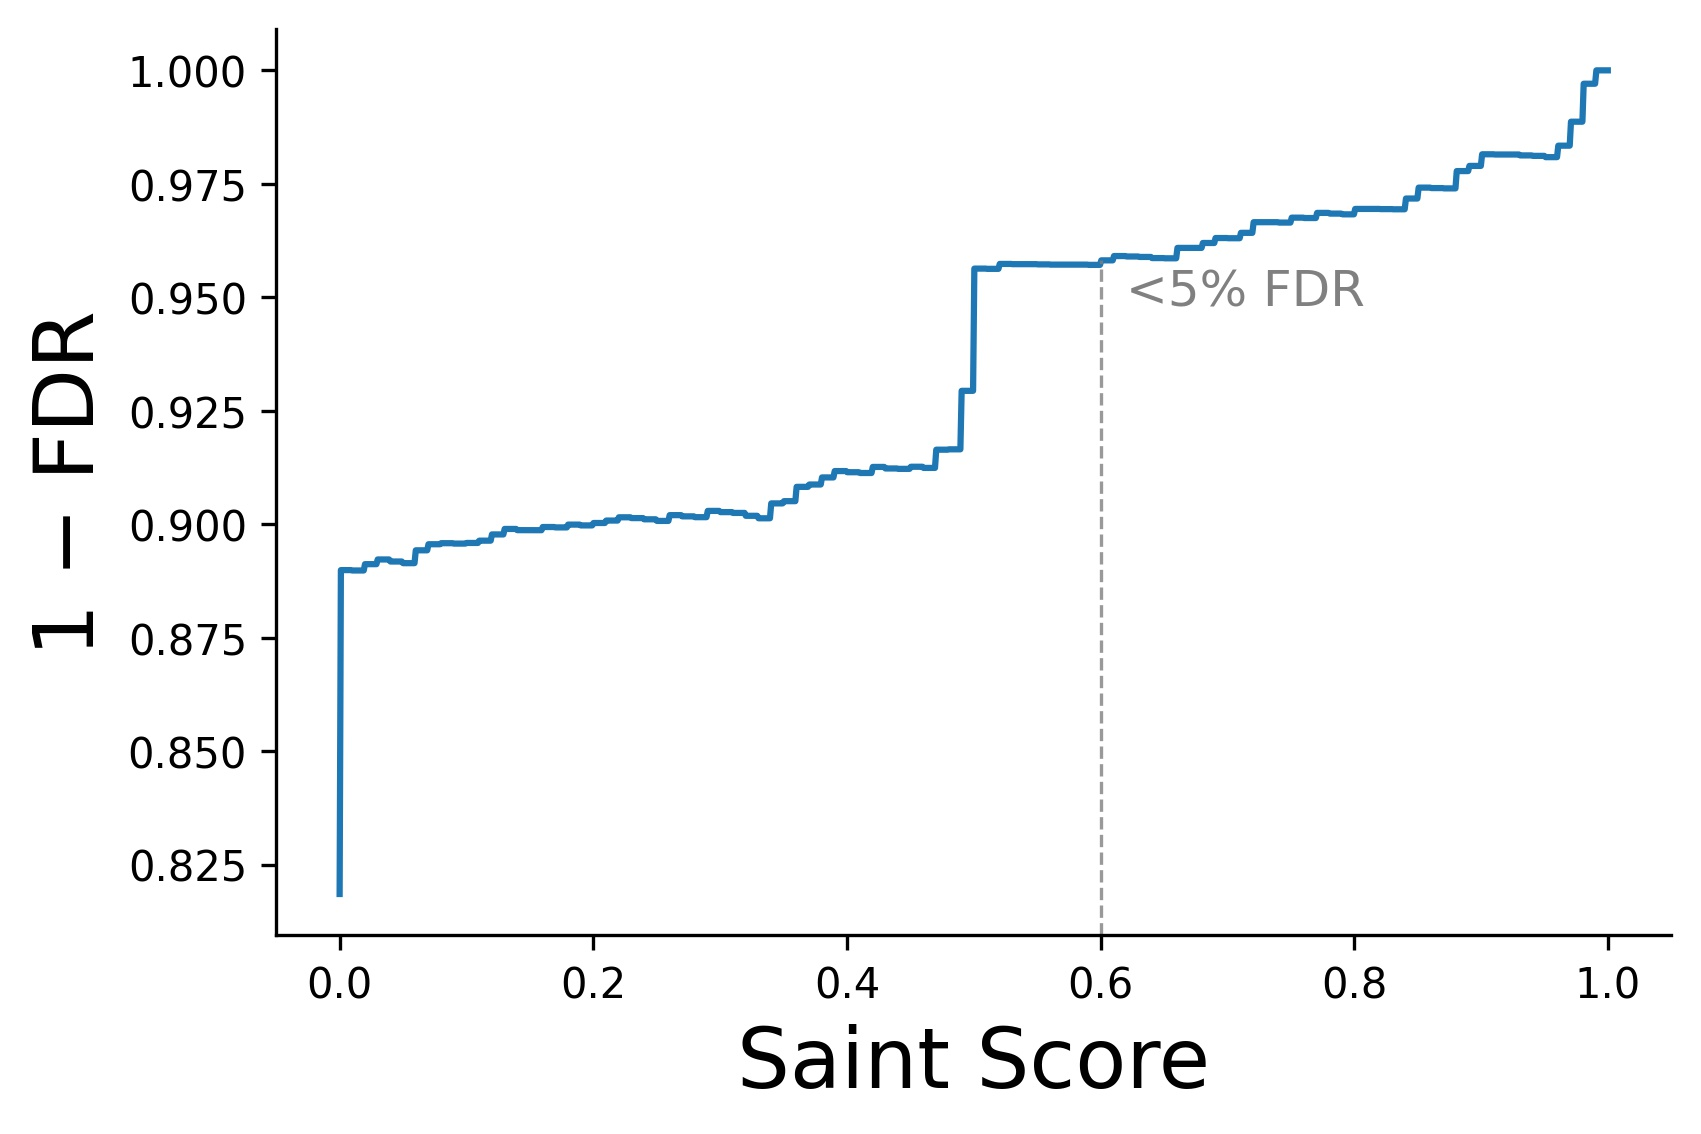

In [82]:
fig, ax = plt.subplots()
sns.lineplot(x='cutoff', y='1-fdr', data=CUTOFF_df1)
ax.set_xlabel('Saint Score', size=20)
ax.set_ylabel('1 − FDR', size=20)
ax.spines['right'].set_visible(None)
ax.spines['top'].set_visible(None)
ymax = CUTOFF_df1[CUTOFF_df1['cutoff']>=0.6]['1-fdr'].min()
ylim = ax.get_ylim()[1] - ax.get_ylim()[0]
ymax_pos = ymax - ax.get_ylim()[0]
ax.axvline(x=.6, ymax=ymax_pos / ylim, 
           linestyle='--', linewidth=.8, 
           alpha=.8, color='grey')
import matplotlib.transforms as transforms
trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.text(s='<5% FDR', x=.6+.02, y=(ymax_pos / ylim)-.05, fontsize=12, color='grey', transform=trans)

In [83]:
hcm_df5 = hcm_df4[hcm_df4['SaintScore']>=.6]

### PhaSePred in HumanCellMap proteome

In [84]:
HumanCellMap_df = hcm_df5[['uniprot_id_0', 'uniprot_id_1']].reset_index(drop=True)
HumanCellMap_ntk = network(HumanCellMap_df)

In [85]:
HumanCellMap_PhaSePred_df = phaSePred_df3[phaSePred_df3['entry'].isin(HumanCellMap_ntk.interactome_prots)]\
                            .reset_index(drop=True)

In [86]:
len1, len2 = len(network(HumanCellMap_df).interactome_codes), len(network(HumanCellMap_df).interactome_prots)
print("interactions_num:{0}, proteins_num:{1}".format(len1, len2))

interactions_num:38175, proteins_num:4200


In [87]:
set(HumanCellMap_ntk.interactome_prots) - set(HumanCellMap_PhaSePred_df['entry'])

set()

In [88]:
# assign 'bait' label to proteins
HumanCellMap_PhaSePred_df.loc[HumanCellMap_PhaSePred_df['entry'].isin(baits_hcm_set), 'bait'] = 1
HumanCellMap_PhaSePred_df['bait'] = HumanCellMap_PhaSePred_df['bait'].fillna(0)
HumanCellMap_PhaSePred_df['bait'] = HumanCellMap_PhaSePred_df['bait'].astype(np.int)

In [89]:
HumanCellMap_PhaSePred_df

,entry,SaPS-8fea,PdPS-8fea,SaPS-10fea,PdPS-10fea,SaPS-8fea_rnk,PdPS-8fea_rnk,SaPS-10fea_rnk,PdPS-10fea_rnk,bait
0,A0AV96,0.335920,0.367314,0.329001,0.257143,0.738748,0.602798,0.790822,0.629399,0
1,A0FGR8,0.075430,0.336415,0.421148,0.709921,0.363730,0.574037,0.820221,0.879460,0
2,A0JNW5,0.111716,0.520182,0.552874,0.824961,0.496933,0.744834,0.861006,0.934724,0
3,A0MZ66,0.589934,0.690497,0.837412,0.845586,0.880982,0.887117,0.951460,0.945865,0
4,A1L0T0,0.061166,0.150959,0.060635,0.063410,0.229350,0.375509,0.299975,0.329963,0
...,...,...,...,...,...,...,...,...,...,...
4195,Q9Y6V7,0.130218,0.166965,0.086225,0.062952,0.541595,0.398626,0.552834,0.328000,0
4196,Q9Y6W5,0.496727,0.705361,0.756915,0.914464,0.833963,0.898601,0.921571,0.982184,0
4197,Q9Y6X4,0.527231,0.679125,0.758714,0.892181,0.848589,0.879215,0.921914,0.969767,0
4198,Q9Y6X9,0.613351,0.795131,0.677466,0.905043,0.890012,0.956466,0.895902,0.976933,0


In [90]:
HumanCellMap_PhaSePred_df['bait'].value_counts()

0    4026
1     174
Name: bait, dtype: int64

#### #### PS ability of Baits vs human proteome

In [91]:
val0 = phaSePred_df2['SaPS-10fea']
val1 = HumanCellMap_PhaSePred_df[HumanCellMap_PhaSePred_df['bait']==1]['SaPS-10fea']
from scipy.stats import mannwhitneyu
_, p = mannwhitneyu(val0, val1)
print(val0.median(), val1.median(), p)

0.077214539051055 0.44498574733734053 8.721470469679542e-31


In [92]:
val0 = phaSePred_df2['PdPS-10fea']
val1 = HumanCellMap_PhaSePred_df[HumanCellMap_PhaSePred_df['bait']==1]['PdPS-10fea']
from scipy.stats import mannwhitneyu
_, p = mannwhitneyu(val0, val1)
print(val0.median(), val1.median(), p)

0.139593452215194 0.640232533216476 1.7284848744737552e-34


## QUBIC

In [9]:
qubic_df = pd.read_excel('./data/Interactome-Datasets/QUBIC_2015.xlsx', sheet_name=1)

In [14]:
# pd.concat([qubic_df['bait.Gene.name'], qubic_df['prey.Gene.name']]).drop_duplicates()

### Changing isoform to classic

In [94]:
# split multiple uniprot accessions
qubic_df1 = split_items(split_items(qubic_df, 'prey.IDs', ';'), 'bait.IDs', ';')

# isoform2classic
# uniprot_id_0: bait, uniprot_id_1: prey
qubic_df1['uniprot_id_0'] = qubic_df1['bait.IDs'].apply(lambda x: x.split('-')[0])
qubic_df1['uniprot_id_1'] = qubic_df1['prey.IDs'].apply(lambda x: x.split('-')[0])
# QUBIC baits
baits_qubic_set = set(qubic_df1['uniprot_id_0'])

# within human proteome (UniProt-SwissPort, Release 2022_03)
qubic_df2 = qubic_df1[(qubic_df1['uniprot_id_0'].isin(humanProte_set))&(qubic_df1['uniprot_id_1'].isin(humanProte_set))]

In [95]:
qubic_df3 = qubic_df2[['uniprot_id_0', 'uniprot_id_1', 'interactor.confidence.class']].copy()

### Drop duplicates and self-interactions

In [96]:
# drop duplicates
qubic_df4 = rm_duplicates(qubic_df3)

# drop self-interactions
qubic_df5 = rm_self_interactions(qubic_df4)

In [97]:
qubic_df5

,uniprot_id_0,uniprot_id_1,interactor.confidence.class,code
0,Q66GS9,P20073,B,P20073Q66GS9
1,Q66GS9,O75970,B-,O75970Q66GS9
2,Q66GS9,O15182,A+,O15182Q66GS9
3,Q66GS9,Q86UR5,A,Q66GS9Q86UR5
6,Q66GS9,Q96KV7,B,Q66GS9Q96KV7
...,...,...,...,...
31939,P29590,Q9BXI9,B+,P29590Q9BXI9
31940,P29590,Q9NSC5,B-,P29590Q9NSC5
31941,P29590,Q9NVH2,B,P29590Q9NVH2
31942,P29590,Q9P2M4,B,P29590Q9P2M4


### Interactor.confidence.class CUTOFF

In [98]:
# assign 0/1 to benchmark interactomes
benchmarking_df['QUBIC_label'] = benchmarking_df[3]
benchmarking_df.loc[benchmarking_df[2].isin(set(qubic_df5[qubic_df5['interactor.confidence.class']=='A+']['code'])), 
                    'QUBIC_label'] = 1
benchmarking_df['QUBIC_label'] = benchmarking_df['QUBIC_label'].fillna(0)

In [99]:
benchmarking_df['QUBIC_label'].value_counts()

0.0    549855
1.0     51940
Name: QUBIC_label, dtype: int64

In [100]:
benchmarking_QUBIC_pos = set(benchmarking_df[benchmarking_df['QUBIC_label']==1][2])
benchmarking_QUBIC_neg = set(benchmarking_df[benchmarking_df['QUBIC_label']==0][2])

In [101]:
print(len(benchmarking_QUBIC_neg)/len(benchmarking_QUBIC_pos))

10.5863496341933


In [102]:
# class to numerical level
classes = np.sort(qubic_df5['interactor.confidence.class'].unique()).tolist()
nums = [len(classes)-i for i in range(len(classes))]
class2num_dict = {
    'A+': 8, 
    'A': 7, 
    'A-': 6, 
    'B+': 5, 
    'B': 4, 
    'B-': 3, 
    'C+': 2,
    'C': 1
}
qubic_df5['class.num'] = qubic_df5['interactor.confidence.class'].map(class2num_dict)

/home/lyz/anaconda3/envs/GCN_cox/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [103]:
class2num_dict

{'A+': 8, 'A': 7, 'A-': 6, 'B+': 5, 'B': 4, 'B-': 3, 'C+': 2, 'C': 1}

In [104]:
CUTOFF = nums[0]
pred_pos = set(qubic_df5[qubic_df5['class.num']>=CUTOFF]['code'])
true_pos = pred_pos & benchmarking_QUBIC_pos
fals_pos = pred_pos & benchmarking_QUBIC_neg
fdr = len(fals_pos) / (len(fals_pos) + len(true_pos))
print(CUTOFF, 1 - fdr)

8 1.0


In [105]:
results = list()
for CUTOFF in nums:
    pred_pos = set(qubic_df5[qubic_df5['class.num']>=CUTOFF]['code'])
    true_pos = pred_pos & benchmarking_QUBIC_pos
    fals_pos = pred_pos & benchmarking_QUBIC_neg
    fdr = len(fals_pos) / (len(fals_pos) + len(true_pos))
    results.append(1-fdr)

In [106]:
CUTOFF_df2 = pd.DataFrame({'class': class2num_dict.keys(), '1-fdr': results})

[Text(0, 0, 'A+'),
 Text(0, 0, 'A'),
 Text(0, 0, 'A-'),
 Text(0, 0, 'B+'),
 Text(0, 0, 'B'),
 Text(0, 0, 'B-'),
 Text(0, 0, 'C+'),
 Text(0, 0, 'C')]

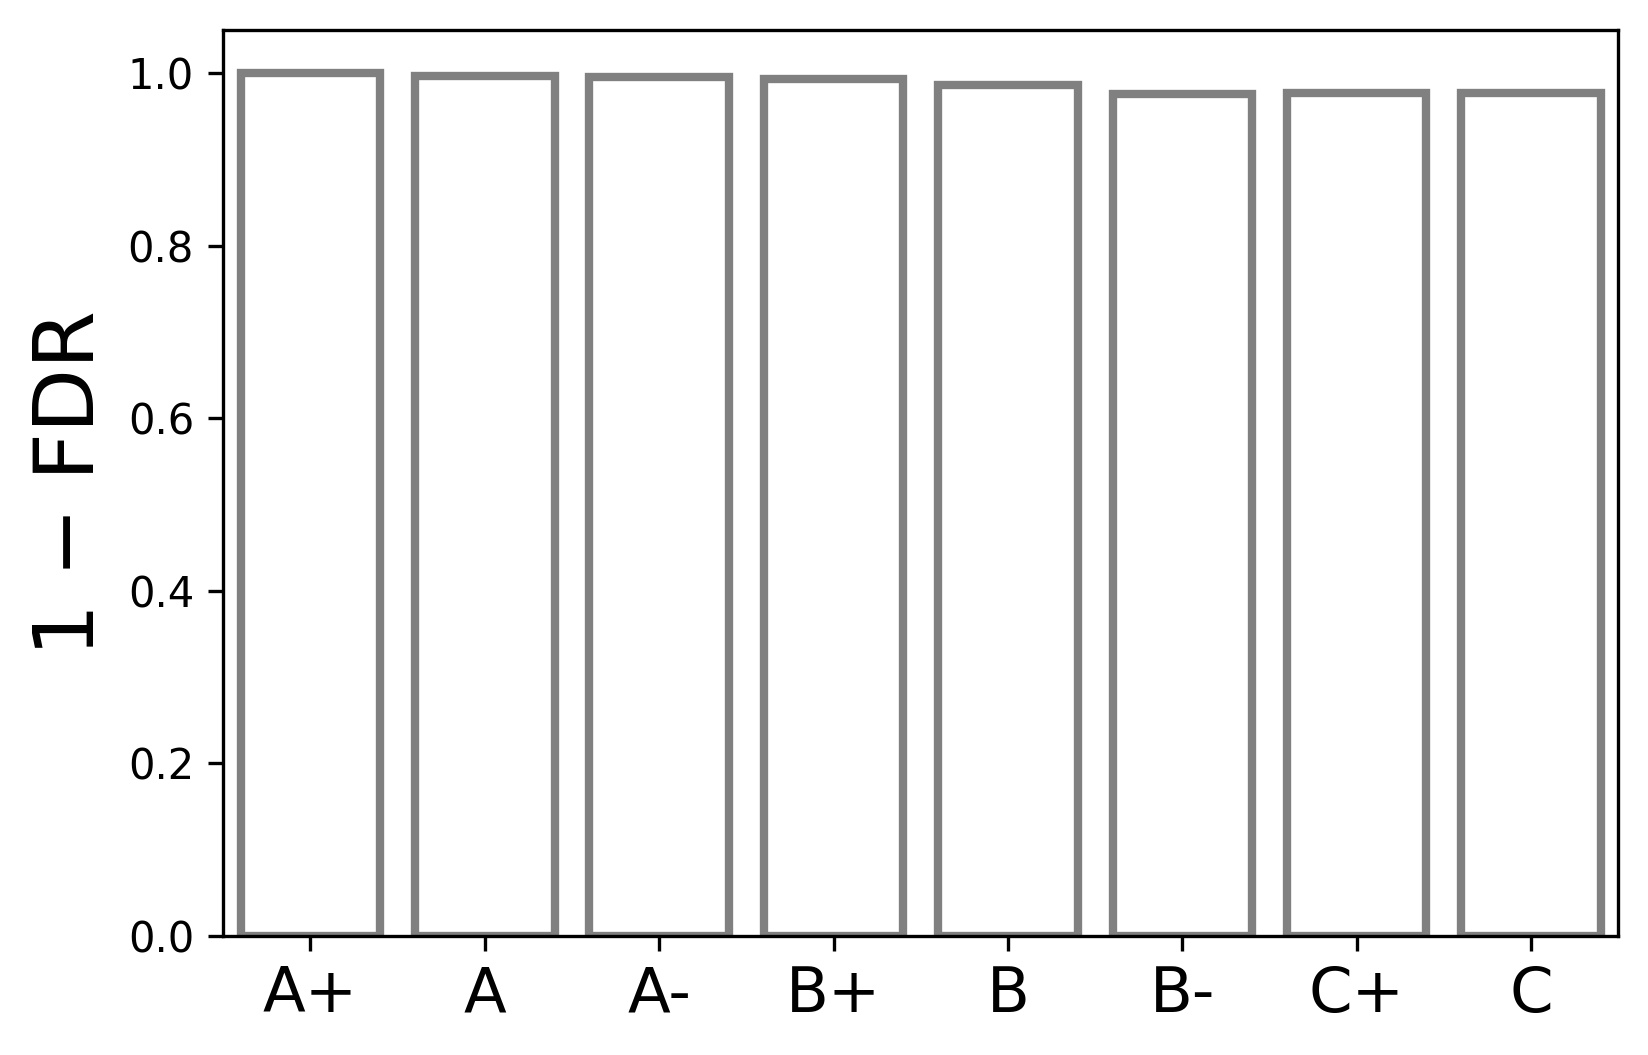

In [107]:
fig, ax = plt.subplots()
sns.barplot(x='class', y='1-fdr', data=CUTOFF_df2, 
            linewidth=2, edgecolor='.5', facecolor=(0, 0, 0, 0))
ax.set_xlabel(None)
ax.set_ylabel('1 − FDR', size=20)
ax.set_xticklabels(class2num_dict.keys(), size=15)

### PhaSePred in QUBIC proteome

In [108]:
QUBIC_df = qubic_df5[['uniprot_id_0', 'uniprot_id_1']].reset_index(drop=True)
QUBIC_ntk = network(QUBIC_df)

In [109]:
QUBIC_PhaSePred_df = phaSePred_df3[phaSePred_df3['entry'].isin(QUBIC_ntk.interactome_prots)].reset_index(drop=True)

In [110]:
len1, len2 = len(QUBIC_ntk.interactome_codes), len(QUBIC_ntk.interactome_prots)
print("interactions_num:{0}, proteins_num:{1}".format(len1, len2))

interactions_num:27158, proteins_num:5425


In [111]:
set(QUBIC_ntk.interactome_prots) - set(QUBIC_PhaSePred_df['entry'])

set()

In [112]:
# assign 'bait' label to proteins
QUBIC_PhaSePred_df.loc[QUBIC_PhaSePred_df['entry'].isin(baits_qubic_set), 'bait'] = 1
QUBIC_PhaSePred_df['bait'] = QUBIC_PhaSePred_df['bait'].fillna(0)
QUBIC_PhaSePred_df['bait'] = QUBIC_PhaSePred_df['bait'].astype(np.int)

In [113]:
QUBIC_PhaSePred_df

,entry,SaPS-8fea,PdPS-8fea,SaPS-10fea,PdPS-10fea,SaPS-8fea_rnk,PdPS-8fea_rnk,SaPS-10fea_rnk,PdPS-10fea_rnk,bait
0,A0AV96,0.335920,0.367314,0.329001,0.257143,0.738748,0.602798,0.790822,0.629399,0
1,A0AVT1,0.083043,0.194866,0.057864,0.225724,0.415215,0.433423,0.244957,0.602209,1
2,A0FGR8,0.075430,0.336415,0.421148,0.709921,0.363730,0.574037,0.820221,0.879460,0
3,A0JNW5,0.111716,0.520182,0.552874,0.824961,0.496933,0.744834,0.861006,0.934724,0
4,A0MZ66,0.589934,0.690497,0.837412,0.845586,0.880982,0.887117,0.951460,0.945865,0
...,...,...,...,...,...,...,...,...,...,...
5420,Q9Y6X3,0.060275,0.199113,0.056125,0.035211,0.216687,0.437939,0.213939,0.135853,1
5421,Q9Y6X8,0.406643,0.624440,0.362849,0.630864,0.781153,0.836712,0.801767,0.841865,0
5422,Q9Y6X9,0.613351,0.795131,0.677466,0.905043,0.890012,0.956466,0.895902,0.976933,0
5423,Q9Y6Y0,0.053662,0.267743,0.384497,0.587275,0.141301,0.507975,0.809620,0.820908,0


In [114]:
QUBIC_PhaSePred_df['bait'].value_counts()

0    4305
1    1120
Name: bait, dtype: int64

#### PS ability of Baits vs human proteome

In [115]:
val0 = phaSePred_df2['SaPS-10fea']
val1 = QUBIC_PhaSePred_df[QUBIC_PhaSePred_df['bait']==1]['SaPS-10fea']
from scipy.stats import mannwhitneyu
_, p = mannwhitneyu(val0, val1)
print(val0.median(), val1.median(), p)

0.077214539051055 0.3036090284585945 3.728290642062169e-67


In [116]:
val0 = phaSePred_df2['PdPS-10fea']
val1 = QUBIC_PhaSePred_df[QUBIC_PhaSePred_df['bait']==1]['PdPS-10fea']
from scipy.stats import mannwhitneyu
_, p = mannwhitneyu(val0, val1, alternative='less')
print(val0.median(), val1.median(), p)

0.139593452215194 0.5407926142215725 2.5043432267279645e-148


## Co-Fractionation

In [15]:
cofrac_df = pd.read_table('./data/Interactome-Datasets/High_confidence_16655_correlations_and_ppi_scores.txt')

In [21]:
pd.concat([cofrac_df['id1'], cofrac_df['id2']]).drop_duplicates()

0        ENSG00000117360
1        ENSG00000167863
2        ENSG00000142937
3        ENSG00000004455
4        ENSG00000184009
              ...       
16456    ENSG00000175550
16523    ENSG00000145675
16538    ENSG00000156384
16541    ENSG00000116957
16574    ENSG00000145703
Length: 3464, dtype: object

### Mapping ENSG to UniProt-SwissProt

In [118]:
# mapping ensg to uniprot
cofrac_df['uniprot_id_0'] = cofrac_df['id1'].map(ensg2uniprot_dict)
cofrac_df['uniprot_id_1'] = cofrac_df['id2'].map(ensg2uniprot_dict)

# remove ensg NA
cofrac_df1 = cofrac_df[(cofrac_df['uniprot_id_0'].notna())&(cofrac_df['uniprot_id_1'].notna())]

# split multiple ensg accessions
cofrac_df2 = split_items(split_items(cofrac_df1, 'uniprot_id_0', ','), 'uniprot_id_1', ',')

# within human proteome (UniProt-SwissProt, Release 2022_03)
cofrac_df3 = cofrac_df2[(cofrac_df2['uniprot_id_0'].isin(humanProte_set))&(cofrac_df2['uniprot_id_1'].isin(humanProte_set))]

In [119]:
cofrac_df4 = cofrac_df3[['uniprot_id_0', 'uniprot_id_1', 'ppi_score']].copy()

### Drop duplicates and self-interactions

In [120]:
# drop duplicates
cofrac_df5 = rm_duplicates(cofrac_df4)

# drop self-interactions
cofrac_df6 = rm_self_interactions(cofrac_df5)

### ppi_score CUTOFF

In [121]:
# assign 0/1 to benchmark interactomes
benchmarking_df['CoFrac_label'] = benchmarking_df[3]
benchmarking_df.loc[benchmarking_df[2].isin(set(cofrac_df6[cofrac_df6['ppi_score']==1]['code'])), 'CoFrac_label'] = 1
benchmarking_df['CoFrac_label'] = benchmarking_df['CoFrac_label'].fillna(0)

In [122]:
benchmarking_df['CoFrac_label'].value_counts()

0.0    549867
1.0     51928
Name: CoFrac_label, dtype: int64

In [123]:
benchmarking_CoFrac_pos = set(benchmarking_df[benchmarking_df['CoFrac_label']==1][2])
benchmarking_CoFrac_neg = set(benchmarking_df[benchmarking_df['CoFrac_label']==0][2])

In [124]:
print(len(benchmarking_CoFrac_neg)/len(benchmarking_CoFrac_pos))

10.589027114466184


In [125]:
CUTOFFs = np.linspace(0, 1, 1000)

In [126]:
CUTOFF = CUTOFFs[0]
pred_pos = set(cofrac_df6[cofrac_df6['ppi_score']>=CUTOFF]['code'])
true_pos = pred_pos & benchmarking_CoFrac_pos
fals_pos = pred_pos & benchmarking_CoFrac_neg
fdr = len(fals_pos) / (len(fals_pos) + len(true_pos))
print(CUTOFF, 1 - fdr)

0.0 0.9943644333124608


### PhaSePred in CoFrac proteome

In [127]:
CoFrac_df = cofrac_df6[['uniprot_id_0', 'uniprot_id_1']].reset_index(drop=True)
CoFrac_ntk = network(CoFrac_df)

In [132]:
CoFrac_PhaSePred_df = phaSePred_df3[phaSePred_df3['entry'].isin(CoFrac_ntk.interactome_prots)]\
                        .reset_index(drop=True)

In [133]:
len1, len2 = len(CoFrac_ntk.interactome_codes), len(CoFrac_ntk.interactome_prots)
print("interactions_num:{0}, proteins_num:{1}".format(len1, len2))

interactions_num:16337, proteins_num:3424


In [134]:
set(CoFrac_ntk.interactome_prots) - set(CoFrac_PhaSePred_df['entry'])

set()

In [135]:
CoFrac_PhaSePred_df

,entry,SaPS-8fea,PdPS-8fea,SaPS-10fea,PdPS-10fea,SaPS-8fea_rnk,PdPS-8fea_rnk,SaPS-10fea_rnk,PdPS-10fea_rnk
0,A0AVT1,0.083043,0.194866,0.057864,0.225724,0.415215,0.433423,0.244957,0.602209
1,A0JLT2,0.704023,0.573129,0.804082,0.806212,0.927558,0.793718,0.937963,0.924859
2,A0MZ66,0.589934,0.690497,0.837412,0.845586,0.880982,0.887117,0.951460,0.945865
3,A1KZ92,0.055849,0.338874,0.066572,0.060408,0.170061,0.576442,0.391902,0.317301
4,A1L0T0,0.061166,0.150959,0.060635,0.063410,0.229350,0.375509,0.299975,0.329963
...,...,...,...,...,...,...,...,...,...
3419,Q9Y6W5,0.496727,0.705361,0.756915,0.914464,0.833963,0.898601,0.921571,0.982184
3420,Q9Y6X3,0.060275,0.199113,0.056125,0.035211,0.216687,0.437939,0.213939,0.135853
3421,Q9Y6X9,0.613351,0.795131,0.677466,0.905043,0.890012,0.956466,0.895902,0.976933
3422,Q9Y6Y8,0.757756,0.711866,0.565595,0.776295,0.949399,0.902724,0.864491,0.909840


## PROPER-seq

In [136]:
proper_df = pd.read_csv('./data/Interactome-Datasets/PROPER_v1.csv')

### Mapping Gene Symbol to UniProt-SwissProt

In [137]:
# mapping gene symbol to uniprot
proper_df['uniprot_id_0'] = proper_df['Gene1'].map(genesymbol2uniprot_dict)
proper_df['uniprot_id_1'] = proper_df['Gene2'].map(genesymbol2uniprot_dict)

# within human proteome (UniProt-SwissProt, Release 2022_03)
proper_df1 = proper_df[(proper_df['uniprot_id_0'].isin(humanProte_set))&(proper_df['uniprot_id_1'].isin(humanProte_set))]

### Keep shared interactions only & drop potential background contaminations

In [138]:
proper_df2 = proper_df1[(proper_df1['Potential background contamination']!=1)&
                        (proper_df1['Cell line specificity']=='shared')]

### Drop duplicates and self-interactions

In [139]:
# drop duplicates
proper_df3 = rm_duplicates(proper_df2)

# drop self-interactions
proper_df4 = rm_self_interactions(proper_df3)

/home/lyz/anaconda3/envs/GCN_cox/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


### PhaSePred in PROPER-seq proteome

In [140]:
PROPERseq_df = proper_df4[['uniprot_id_0', 'uniprot_id_1']].reset_index(drop=True)
PROPERseq_ntk = network(PROPERseq_df)

In [143]:
PROPERseq_PhaSePred_df = phaSePred_df3[phaSePred_df3['entry'].isin(PROPERseq_ntk.interactome_prots)]\
                            .reset_index(drop=True)

In [144]:
len1, len2 = len(PROPERseq_ntk.interactome_codes), len(PROPERseq_ntk.interactome_prots)
print("interactions_num:{0}, proteins_num:{1}".format(len1, len2))

interactions_num:134336, proteins_num:7414


In [145]:
set(PROPERseq_ntk.interactome_prots) - set(PROPERseq_PhaSePred_df['entry'])

set()

In [146]:
PROPERseq_PhaSePred_df

,entry,SaPS-8fea,PdPS-8fea,SaPS-10fea,PdPS-10fea,SaPS-8fea_rnk,PdPS-8fea_rnk,SaPS-10fea_rnk,PdPS-10fea_rnk
0,A0A087WUL8,0.530787,0.613968,0.119373,0.169447,0.850356,0.827534,0.648294,0.541791
1,A0A087X1G2,0.503892,0.732808,0.156825,0.106729,0.837840,0.917595,0.697325,0.448000
2,A0A096LP01,0.070014,0.151015,0.071313,0.077698,0.318577,0.375755,0.454429,0.380368
3,A0A096LP55,0.137536,0.420869,0.046679,0.279634,0.556319,0.651288,0.021693,0.648687
4,A0A0B4J2F0,0.146357,0.483785,0.105351,0.272333,0.573301,0.710479,0.615558,0.642061
...,...,...,...,...,...,...,...,...,...
7409,Q9Y6X4,0.527231,0.679125,0.758714,0.892181,0.848589,0.879215,0.921914,0.969767
7410,Q9Y6X9,0.613351,0.795131,0.677466,0.905043,0.890012,0.956466,0.895902,0.976933
7411,Q9Y6Y0,0.053662,0.267743,0.384497,0.587275,0.141301,0.507975,0.809620,0.820908
7412,Q9Y6Y1,0.479397,0.593515,0.103712,0.191657,0.824147,0.810994,0.611534,0.569423


# Save pickle

In [149]:
interactome_List = ['HuRI', 'BioPlex3.0', 'Human Cell Map', 'QUBIC', 'CoFrac']
phasepred_df_List = [HuRI_PhaSePred_df, BioPlex_PhaSePred_df, HumanCellMap_PhaSePred_df, 
                     QUBIC_PhaSePred_df, CoFrac_PhaSePred_df]
interactome2PhaSePred_dict = dict(zip(interactome_List, phasepred_df_List))

In [151]:
# # save pickle
# with open('./reults_data/interactome.phasepred.pkl', 'wb') as f:
#     pickle.dump(interactome2PhaSePred_dict, f)

# PS ability difference among each Interacteome? 
* scatterplot & kdeplot (with interactome, 10-features)

In [135]:
dat_plt2 = phaSePred_df2[['entry', 'PdPS-10fea', 'SaPS-10fea']].copy()

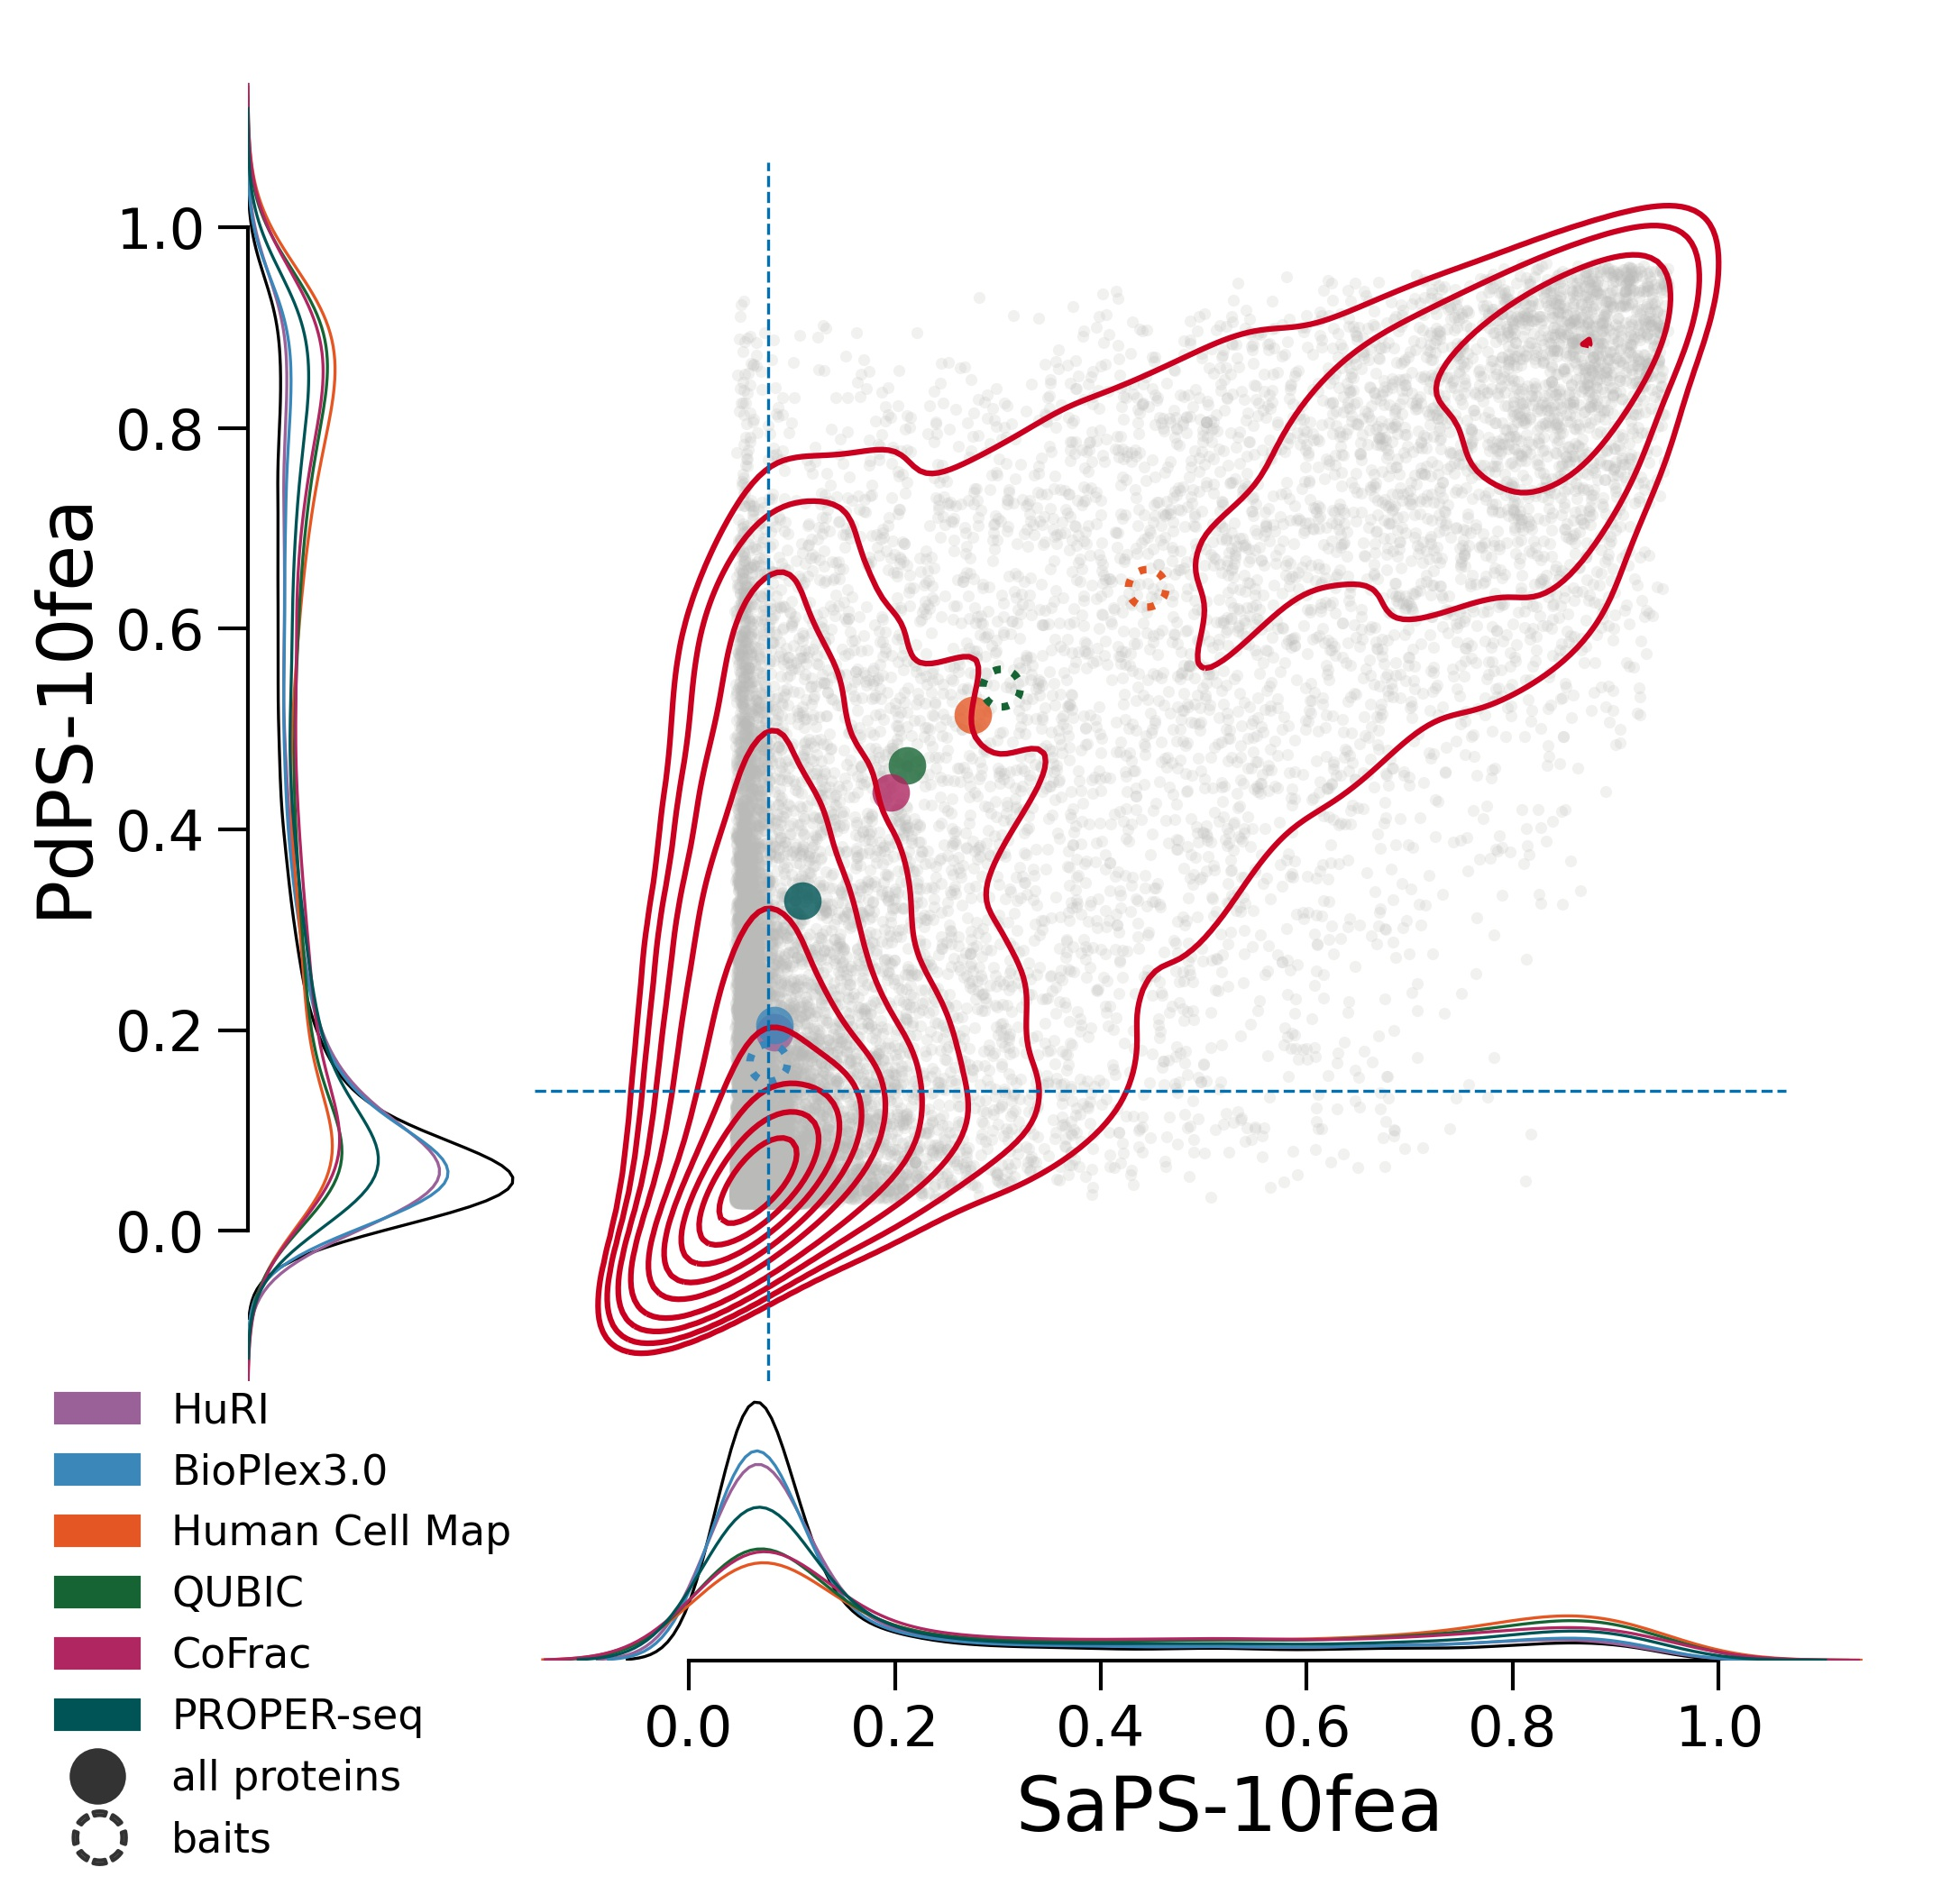

In [136]:
fig, [[ax1,ax2], [ax3, ax4]] = plt.subplots(
    nrows=2, 
    ncols=2, 
    figsize=(8, 8),
    sharex='col',
    sharey='row',
    gridspec_kw={'height_ratios': [5, 1], 'width_ratios': [1, 5]}
)
plt.subplots_adjust(wspace=.01, hspace=.01)
axs = [ax1, ax2, ax3, ax4]
x, y = 'SaPS-10fea', 'PdPS-10fea'

# scatterplot & kdeplot (ax2)
sns.scatterplot(x=x, y=y, data=dat_plt2, 
                linewidth=0, alpha=.2, 
                s=10, color='#BABAB8', ax=ax2)
sns.kdeplot(x=x, y=y, data=dat_plt2, 
            color='#C9001F', ax=ax2)
ax2.set_xlim([-.15, 1.2])
ax2.set_ylim([-.15, 1.2])
ax2.set_xticks([round(i, 2) for i in np.arange(0, 1.2, .2)])
ax2.set_yticks([round(i, 2) for i in np.arange(0, 1.2, .2)])
for c in ['top', 'bottom', 'left', 'right']:
    ax2.spines[c].set_visible(None)
ax2.tick_params(bottom=False, left=False)
ax2.set_xlabel(None)
ax2.set_ylabel(None)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
color_dotline = '#0570AF'
# highest density
# ax2.axvline(x=estimate_maxima(dat_plt2[x]), ymin=.0, ymax=.9, ls='--', color=color_dotline, linewidth=.8)
# ax2.axhline(y=estimate_maxima(dat_plt2[y]), xmin=.0, xmax=.9, ls='--', color=color_dotline, linewidth=.8)
# median
ax2.axvline(x=dat_plt2[x].median(), ymin=.0, ymax=.9, ls='--', color=color_dotline, linewidth=.8)
ax2.axhline(y=dat_plt2[y].median(), xmin=.0, xmax=.9, ls='--', color=color_dotline, linewidth=.8)

# legend (ax3)
# without border
for c in ['top', 'bottom', 'left', 'right']:
    ax3.spines[c].set_visible(None)
ax3.tick_params(bottom=False, left=False)
ax3.set_xticklabels([])
ax3.set_yticklabels([])
# color legend
interactome2color_dict = {
    'HuRI': '#9A6199',
    'BioPlex3.0': '#3C87B9',
    'Human Cell Map': '#E45724',
    'QUBIC': '#166433',
    'CoFrac': '#AF2661',
    'PROPER-seq': '#005456'
}
red_patches = [mpatches.Patch(color=val, label=key) for key, val in interactome2color_dict.items()]
# dot legend
markerfacecolor = 'k'
line1 = Line2D([], [], 
               alpha=.8, 
               linewidth=0, 
               label='all proteins', 
               marker='o', 
               markersize=15,
               markeredgewidth=0, 
               markerfacecolor=markerfacecolor)
line2 = Line2D([], [], 
               alpha=.8,
               linewidth=0,
               label='baits',
               marker='$\u25CC$',
               markersize=15,
               markeredgewidth=1,
               markeredgecolor=markerfacecolor,
               markerfacecolor='none')
handles = red_patches + [line1, line2]
ax3.legend(handles=handles, ncol=1, loc=[-.75, -.8], frameon=False, fontsize=11)

# PdPS kdeplot (ax1)
linewidth_kde, linewidth_axis = .8, 1
color_kde, color_axis = 'k', 'k'
sns.kdeplot(y=y, data=dat_plt2, ax=ax1, color=color_kde, linewidth=linewidth_kde)
for c in ['top', 'bottom', 'left', 'right']:
    ax1.spines[c].set_visible(None)
ax1.tick_params(bottom=False, length=8, width=linewidth_axis)
ax1.set_xlabel(None)
ax1.set_xticklabels([])
ax1.set_yticklabels([round(i, 2) for i in np.arange(0, 1.2, .2)], size=15)
# ax1.set_ylim([0, 1])
ax1.set_ylabel(y, size=20)
# adding vertical axis
trans = ax1.get_yaxis_transform()
ax1.plot([.0, .0], [1, .0], color=color_axis, linewidth=linewidth_axis, transform=trans, clip_on=False)

# SaPS kdeplot (ax4)
sns.kdeplot(x=x, data=dat_plt2, ax=ax4, color=color_kde, linewidth=linewidth_kde)
for c in ['top', 'bottom', 'left', 'right']:
    ax4.spines[c].set_visible(None)
ax4.tick_params(left=False, length=8, width=linewidth_axis)
ax4.set_ylabel(None)
ax4.set_yticklabels([])
ax4.set_xticklabels([round(i, 2) for i in np.arange(0, 1.2, .2)], size=15)
# ax4.set_xlim([0, 1])
ax4.set_xlabel(x, size=20)
# adding horizontal axis
trans = ax4.get_xaxis_transform()
ax4.plot([.0, 1], [.0, .0], color=color_axis, linewidth=linewidth_axis, transform=trans, clip_on=False)

# Median Dots & kdeplot
ALPHA = .8
SIZE = 100

interactome2DataFrame_dict = {
    'HuRI': HuRI_PhaSePred_df,
    'BioPlex3.0': BioPlex_PhaSePred_df,
    'Human Cell Map': HumanCellMap_PhaSePred_df,
    'QUBIC': QUBIC_PhaSePred_df,
    'CoFrac': CoFrac_PhaSePred_df,
    'PROPER-seq': PROPERseq_PhaSePred_df
}

for key, val in interactome2DataFrame_dict.items():
    ax2.scatter(x=val[x].median(), 
                y=val[y].median(), 
                c=interactome2color_dict[key], 
                alpha=ALPHA, s=SIZE, linewidth=0)
    DatPlot = val[['entry', x, y]].copy()
    sns.kdeplot(y=y, data=DatPlot, ax=ax1, color=interactome2color_dict[key], linewidth=linewidth_kde)
    sns.kdeplot(x=x, data=DatPlot, ax=ax4, color=interactome2color_dict[key], linewidth=linewidth_kde)

# Bait proteins (BioPlex3.0, Human Cell Map, QUBIC)
# BioPlex3.0
BioPlex_bait_PhaSePred_df = BioPlex_PhaSePred_df[BioPlex_PhaSePred_df['bait']==1].copy()
ax2.scatter(x=BioPlex_bait_PhaSePred_df[x].median(), 
            y=BioPlex_bait_PhaSePred_df[y].median(), 
            facecolor='none', alpha=1, s=SIZE, 
            edgecolor=interactome2color_dict['BioPlex3.0'], 
            linestyle=':', linewidth=2)
# Human Cell Map
HumanCellMap_bait_PhaSePred_df = HumanCellMap_PhaSePred_df[HumanCellMap_PhaSePred_df['bait']==1].copy()
ax2.scatter(x=HumanCellMap_bait_PhaSePred_df[x].median(), 
            y=HumanCellMap_bait_PhaSePred_df[y].median(), 
            facecolor='none', alpha=1, s=SIZE, 
            edgecolor=interactome2color_dict['Human Cell Map'], 
            linestyle=':', linewidth=2)
# QUBIC
QUBIC_bait_PhaSePred_df = QUBIC_PhaSePred_df[QUBIC_PhaSePred_df['bait']==1].copy()
ax2.scatter(x=QUBIC_bait_PhaSePred_df[x].median(), 
            y=QUBIC_bait_PhaSePred_df[y].median(), 
            facecolor='none', alpha=1, s=SIZE, 
            edgecolor=interactome2color_dict['QUBIC'], 
            linestyle=':', linewidth=2)

# Merge

In [159]:
interactome2DataSet_dict = {
    'HuRI': HuRI_df,
    'BioPlex3.0': BioPlex_df,
    'Human Cell Map': HumanCellMap_df,
    'QUBIC': QUBIC_df,
    'CoFrac': CoFrac_df,
    'PROPER-seq': PROPERseq_df
}

In [160]:
datasets = list()
for x in interactome2DataSet_dict.keys():
    tmp_df = interactome2DataSet_dict[x].copy()
    tmp_df['dataset'] = x
    datasets.append(tmp_df)
interactome_df = pd.concat(datasets).reset_index(drop=True)
interactome_df[0] = np.sort(interactome_df[['uniprot_id_0', 'uniprot_id_1']].values).sum(axis=1)

In [161]:
interactome_df

,uniprot_id_0,uniprot_id_1,dataset,0
0,Q9H2S6,Q9NPE6,HuRI,Q9H2S6Q9NPE6
1,Q9H2S6,Q9BXK5,HuRI,Q9BXK5Q9H2S6
2,Q9H2S6,O60238,HuRI,O60238Q9H2S6
3,Q9H2S6,P20138,HuRI,P20138Q9H2S6
4,Q9H2S6,Q9UM44,HuRI,Q9H2S6Q9UM44
...,...,...,...,...
384107,Q15019,O95182,PROPER-seq,O95182Q15019
384108,P06748,Q7Z624,PROPER-seq,P06748Q7Z624
384109,P00558,O43390,PROPER-seq,O43390P00558
384110,Q96T88,O43920,PROPER-seq,O43920Q96T88


In [162]:
# interactome_df.to_pickle('./reults_data/Interactome.Datasets.merge-v1.pkl')

## Interaction of PPIs among Interacteome

In [141]:
from upsetplot import plot
set_names = list(interactome2DataSet_dict.keys())
interactome_sets = [set(interactome_df[interactome_df['dataset']==x][0]) for x in set_names]
all_elems = set.union(*interactome_sets)
df = pd.DataFrame([[e in interactome_sets[j] for j in range(6)] for e in all_elems], columns = set_names)
df['count'] = df.sum(axis=1)

In [142]:
df1 = df[df['count']>1][set_names].reset_index(drop=True)

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7fba4fbc63d0>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7fba474ce910>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7fba217b2610>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7fba21784d10>}

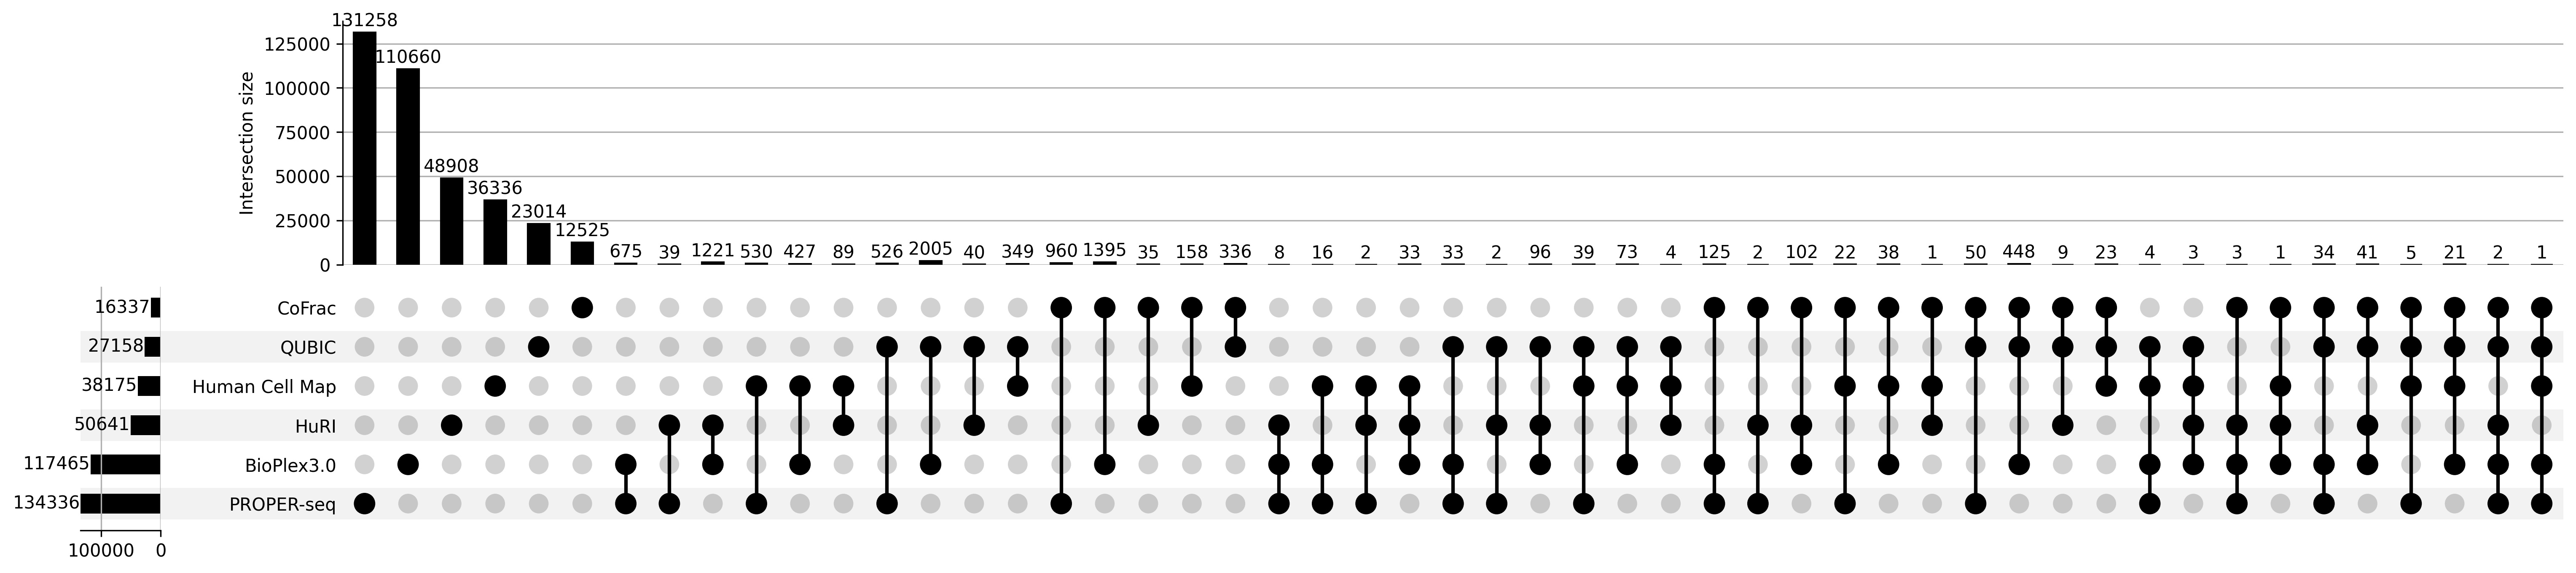

In [143]:
df_up = df.groupby(set_names).size()
plot(df_up, orientation='horizontal', show_counts=True)

In [22]:
interactome_df = pd.read_pickle('./reults_data/Interactome.Datasets.merge-v2.pkl')
interactome_List = interactome_df['dataset'].unique().tolist()

In [23]:
inter2prote_dict = dict()
for x in interactome_List:
    x_df = interactome_df[interactome_df['dataset']==x].reset_index(drop=True)
    inter2prote_dict[x] = set(pd.concat([x_df['uniprot_id_0'], x_df['uniprot_id_1']]).unique().tolist())

In [24]:
prote_intersection_set = set.intersection(*list(inter2prote_dict.values()))

In [25]:
condFormProt_df = pd.read_pickle('./reults_data/human.condensate-formation.proteins-v1.pkl')
condFormProt_List = list(set(condFormProt_df['uniprot_entry']))

In [26]:
print(len(prote_intersection_set), 
      len(prote_intersection_set & set(condFormProt_List)), 
      len(prote_intersection_set - set(condFormProt_List)))

640 306 334


In [29]:
len(inter2prote_dict['HuRI'])

8079

### Intersection of PS proteins for each interactome (venn diagram)

In [220]:
inter2PSprote_dict = dict()
for x in interactome_List:
    x_df = interactome_df[interactome_df['dataset']==x].reset_index(drop=True)
    inter2PSprote_dict[x] = set(pd.concat([x_df['uniprot_id_0'], x_df['uniprot_id_1']]).unique().tolist()) & set(condFormProt_List)

In [227]:
# for x in interactome_List:
#     pd.Series(list(inter2PSprote_dict[x])).to_csv('./reults_data/interactome.ps.proteome/{}.txt'.format(x), 
#                                                   index=None, header=None)

In [224]:
ps_prote_intersection_set = set.intersection(*list(inter2PSprote_dict.values()))

### Calculation of average PhaSePred score for binding partners

In [184]:
phaSePred_df = pd.read_pickle('./reults_data/HUMAN_9606_PhaSePred_SaPS_PdPS.pkl')
entry2saps_dict = phaSePred_df.set_index('entry').to_dict()['SaPS-10fea']
entry2pdps_dict = phaSePred_df.set_index('entry').to_dict()['PdPS-10fea']

In [216]:
from collections import defaultdict
inter2MedPhasepred_dict = defaultdict(dict)
for x in interactome_List:
    x_df = interactome_df[interactome_df['dataset']==x].reset_index(drop=True)
    df = x_df[['uniprot_id_0', 'uniprot_id_1']].copy()
    df_r = df.copy()
    df_r.columns = ['uniprot_id_1', 'uniprot_id_0']
    df_m = pd.concat([df, df_r]).reset_index(drop=True)
    # df_m = df_m[~df_m['uniprot_id_1'].isin(prote_intersection_set)].reset_index(drop=True)
    df_m['saps_1'] = df_m['uniprot_id_1'].map(entry2saps_dict)
    df_m['pdps_1'] = df_m['uniprot_id_1'].map(entry2pdps_dict)
    df_avg = df_m.groupby('uniprot_id_0').mean().reset_index()
    saps_avg = df_avg[df_avg['uniprot_id_0'].isin(prote_intersection_set)]['saps_1'].median()
    pdps_avg = df_avg[df_avg['uniprot_id_0'].isin(prote_intersection_set)]['pdps_1'].median()
    inter2MedPhasepred_dict[x] = {'saps': saps_avg, 'pdps': pdps_avg}
    # print(x, saps_avg, pdps_avg)

In [217]:
inter2MedPhasepred_dict

defaultdict(dict,
            {'HuRI': {'saps': 0.26456873377578094, 'pdps': 0.3779018928358948},
             'BioPlex3.0': {'saps': 0.29622081335822914,
              'pdps': 0.414892039675679},
             'Human Cell Map': {'saps': 0.5021870732307431,
              'pdps': 0.6488060725525906},
             'QUBIC': {'saps': 0.42247904182544727,
              'pdps': 0.5420805427132456},
             'CoFrac': {'saps': 0.4204912179992307, 'pdps': 0.5447491788771}})

In [201]:
# # save pickle
# with open('./reults_data/interactome.shared_med.phasepred.pkl', 'wb') as f:
#     pickle.dump(inter2MedPhasepred_dict, f)

### Visualization

In [205]:
# average phasepred with shared binding partners
with open('./reults_data/interactome.shared_med.phasepred.pkl', 'rb') as f:
    interactome2MedPhaSePred_dict = pickle.load(f)
    
# average phasepred with shared baits
with open('./reults_data/interactome.prey.phasepred.pkl', 'rb') as f:
    interactome2PreyPhaSePred_df = pickle.load(f)
    
# interactome to phasepred dataframe
with open('./reults_data/interactome.phasepred.pkl', 'rb') as f:
    interactome2PhaSePred_dict = pickle.load(f)

In [ ]:
dat_plt3 = phaSePred_df[['entry', 'PdPS-10fea', 'SaPS-10fea']].copy()

In [192]:
dat_plt3

,entry,PdPS-10fea,SaPS-10fea
0,A0A024RBG1,0.277678,0.067231
1,A0A075B6H7,0.028327,0.051780
2,A0A075B6H8,0.041141,0.062311
3,A0A075B6H9,0.029602,0.052514
4,A0A075B6I0,0.031280,0.071784
...,...,...,...
20393,U3KPV4,0.029547,0.065999
20394,W5XKT8,0.031933,0.069281
20395,W6CW81,0.123707,0.048532
20396,X6R8D5,0.156707,0.077814


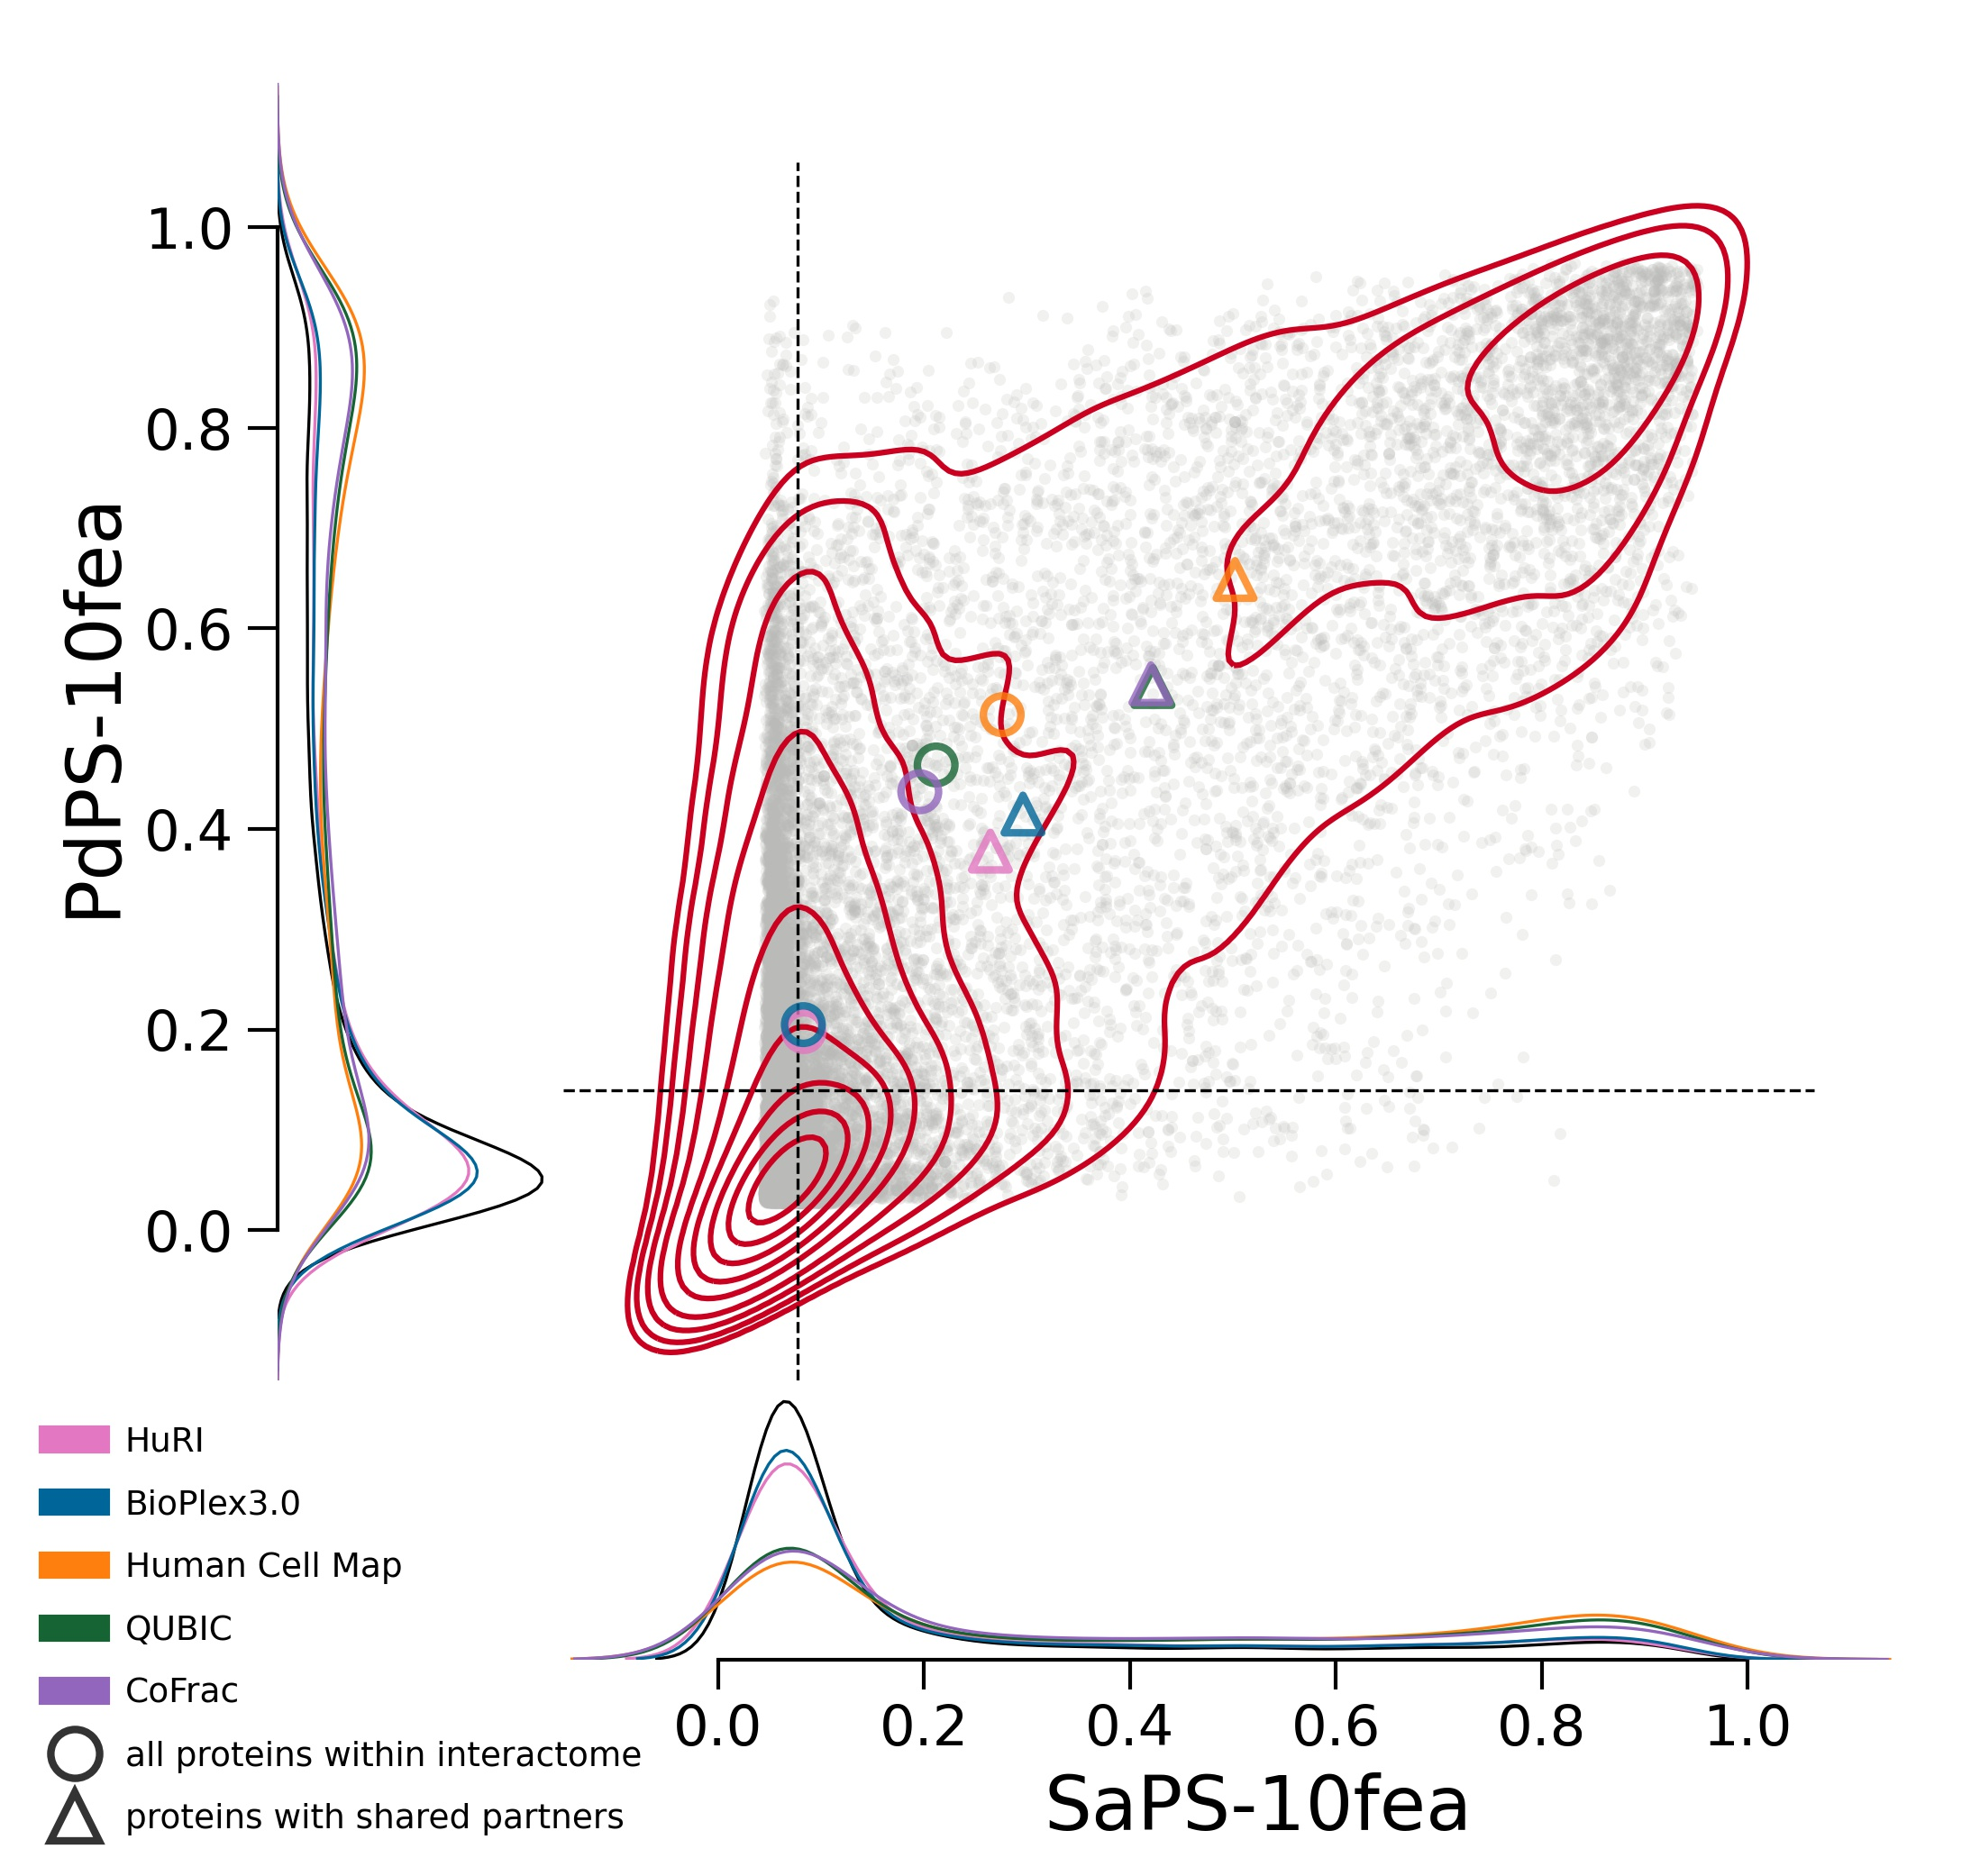

In [218]:
fig, [[ax1,ax2], [ax3, ax4]] = plt.subplots(
    nrows=2, 
    ncols=2, 
    figsize=(8, 8),
    sharex='col',
    sharey='row',
    gridspec_kw={'height_ratios': [5, 1], 'width_ratios': [1, 5]}
)
plt.subplots_adjust(wspace=.01, hspace=.01)
axs = [ax1, ax2, ax3, ax4]
x, y = 'SaPS-10fea', 'PdPS-10fea'

# scatterplot & kdeplot (ax2)
sns.scatterplot(x=x, y=y, data=dat_plt3, 
                linewidth=0, alpha=.2, 
                s=10, color='#BABAB8', ax=ax2)
sns.kdeplot(x=x, y=y, data=dat_plt3, 
            color='#C9001F', ax=ax2)
ax2.set_xlim([-.15, 1.2])
ax2.set_ylim([-.15, 1.2])
ax2.set_xticks([round(i, 2) for i in np.arange(0, 1.2, .2)])
ax2.set_yticks([round(i, 2) for i in np.arange(0, 1.2, .2)])
for c in ['top', 'bottom', 'left', 'right']:
    ax2.spines[c].set_visible(None)
ax2.tick_params(bottom=False, left=False)
ax2.set_xlabel(None)
ax2.set_ylabel(None)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
color_dotline = 'k'
# highest density
# ax2.axvline(x=estimate_maxima(dat_plt2[x]), ymin=.0, ymax=.9, ls='--', color=color_dotline, linewidth=.8)
# ax2.axhline(y=estimate_maxima(dat_plt2[y]), xmin=.0, xmax=.9, ls='--', color=color_dotline, linewidth=.8)
# median
ax2.axvline(x=dat_plt3[x].median(), ymin=.0, ymax=.9, ls='--', color=color_dotline, linewidth=.8)
ax2.axhline(y=dat_plt3[y].median(), xmin=.0, xmax=.9, ls='--', color=color_dotline, linewidth=.8)

# legend (ax3)
# without border
for c in ['top', 'bottom', 'left', 'right']:
    ax3.spines[c].set_visible(None)
ax3.tick_params(bottom=False, left=False)
ax3.set_xticklabels([])
ax3.set_yticklabels([])
# color legend
interactome2color_dict = {
    'HuRI': '#E377C1',
    'BioPlex3.0': '#006699',
    'Human Cell Map': '#FF7F0E',
    'QUBIC': '#166433',
    'CoFrac': '#9366BD'
}
red_patches = [mpatches.Patch(color=val, label=key) for key, val in interactome2color_dict.items()]
# dot legend
markerfacecolor = 'k'
MARKERSIZE = 13
FONTSIZE = 9
line1 = Line2D([], [], 
               alpha=.8, 
               linewidth=0, 
               label='all proteins within interactome', 
               marker='o', 
               markersize=MARKERSIZE,
               markeredgewidth=2, 
               markeredgecolor=markerfacecolor,
               markerfacecolor='none')
line2 = Line2D([], [], 
               alpha=.8,
               linewidth=0,
               label='proteins with shared partners',
               marker='^',
               markersize=MARKERSIZE,
               markeredgewidth=2,
               markeredgecolor=markerfacecolor,
               markerfacecolor='none')
handles = red_patches + [line1, line2]
ax3.legend(handles=handles, ncol=1, loc=[-.9, -.7], 
           frameon=False, fontsize=FONTSIZE, handletextpad=.5, labelspacing=.9)

# PdPS kdeplot (ax1)
linewidth_kde, linewidth_axis = .8, 1
color_kde, color_axis = 'k', 'k'
sns.kdeplot(y=y, data=dat_plt3, ax=ax1, color=color_kde, linewidth=linewidth_kde)
for c in ['top', 'bottom', 'left', 'right']:
    ax1.spines[c].set_visible(None)
ax1.tick_params(bottom=False, length=8, width=linewidth_axis)
ax1.set_xlabel(None)
ax1.set_xticklabels([])
ax1.set_yticklabels([round(i, 2) for i in np.arange(0, 1.2, .2)], size=15)
# ax1.set_ylim([0, 1])
ax1.set_ylabel(y, size=20)
# adding vertical axis
trans = ax1.get_yaxis_transform()
ax1.plot([.0, .0], [1, .0], color=color_axis, linewidth=linewidth_axis, transform=trans, clip_on=False)

# SaPS kdeplot (ax4)
sns.kdeplot(x=x, data=dat_plt3, ax=ax4, color=color_kde, linewidth=linewidth_kde)
for c in ['top', 'bottom', 'left', 'right']:
    ax4.spines[c].set_visible(None)
ax4.tick_params(left=False, length=8, width=linewidth_axis)
ax4.set_ylabel(None)
ax4.set_yticklabels([])
ax4.set_xticklabels([round(i, 2) for i in np.arange(0, 1.2, .2)], size=15)
# ax4.set_xlim([0, 1])
ax4.set_xlabel(x, size=20)
# adding horizontal axis
trans = ax4.get_xaxis_transform()
ax4.plot([.0, 1], [.0, .0], color=color_axis, linewidth=linewidth_axis, transform=trans, clip_on=False)

# Median Dots & kdeplot
ALPHA = .8
SIZE = 100

for key, val in interactome2PhaSePred_dict.items():
    # all proteins
    ax2.scatter(
        x=val[x].median(), 
        y=val[y].median(), 
        edgecolor=interactome2color_dict[key], 
        facecolor='none', alpha=ALPHA, s=SIZE, 
        linewidth=2, marker='o', zorder=5
    )
    # median phasepred with shared binding partners
    ax2.scatter(
        x=inter2MedPhasepred_dict[key]['saps'], 
        y=inter2MedPhasepred_dict[key]['pdps'], 
        edgecolor=interactome2color_dict[key], 
        facecolor='none', alpha=ALPHA, s=SIZE, 
        linewidth=2, marker='^', zorder=5
    )
    DatPlot = val[['entry', x, y]].copy()
    sns.kdeplot(y=y, data=DatPlot, ax=ax1, color=interactome2color_dict[key], linewidth=linewidth_kde)
    sns.kdeplot(x=x, data=DatPlot, ax=ax4, color=interactome2color_dict[key], linewidth=linewidth_kde)

# # median phasepred with shared baits
# for s in ['BioPlex3.0', 'Human Cell Map', 'QUBIC']:
#     ax2.scatter(
#         x=interactome2PreyPhaSePred_df[(interactome2PreyPhaSePred_df['interactome']==s)&
#                        (interactome2PreyPhaSePred_df['fea']==x)]['prey.score.median'].item(), 
#         y=interactome2PreyPhaSePred_df[(interactome2PreyPhaSePred_df['interactome']==s)&
#                        (interactome2PreyPhaSePred_df['fea']==y)]['prey.score.median'].item(),
#         facecolor='none', alpha=ALPHA, s=SIZE, edgecolor=interactome2color_dict[s], 
#         marker='^', linewidth=2
#     )